In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error, r2_score

In [2]:
TARGET_NAME = 'Ewltp (g/km)'
ENEDC_EWLTP_COLNAMES = ['Enedc (g/km)','Ewltp (g/km)']

In [3]:
# !!!!!!!!!!! GARDER CES VALEURS DANS TOUT LE NOTEBOOK !!!!!!!!!!!

TEST_SIZE = .2
RANDOM_STATE = 1492

## Chargement csv clean

In [4]:
df = pd.read_csv('df_clean.zip', index_col='index')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1386787 entries, 0 to 11703799
Data columns (total 16 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Mp            1386787 non-null  object 
 1   Mh            1386787 non-null  object 
 2   Ct            1386787 non-null  object 
 3   Cr            1386787 non-null  object 
 4   M (kg)        1386787 non-null  float64
 5   Mt            1386787 non-null  float64
 6   Enedc (g/km)  1386787 non-null  float64
 7   Ewltp (g/km)  1386787 non-null  float64
 8   W (mm)        1386787 non-null  float64
 9   At1 (mm)      1386787 non-null  float64
 10  At2 (mm)      1386787 non-null  float64
 11  Ft            1386787 non-null  object 
 12  Fm            1386787 non-null  object 
 13  Ec (cm3)      1386787 non-null  float64
 14  Ep (KW)       1386787 non-null  float64
 15  Z (Wh/km)     1386787 non-null  float64
dtypes: float64(10), object(6)
memory usage: 179.9+ MB


In [5]:
# Discrétisation des variables qualitatives
df = pd.get_dummies(df)

In [7]:
# Réduisons la taille mémoire de notre jeu de données en changeant le type de certaines données numériques
df.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1386787 entries, 0 to 11703799
Data columns (total 91 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   M (kg)                            1386787 non-null  float64
 1   Mt                                1386787 non-null  float64
 2   Enedc (g/km)                      1386787 non-null  float64
 3   Ewltp (g/km)                      1386787 non-null  float64
 4   W (mm)                            1386787 non-null  float64
 5   At1 (mm)                          1386787 non-null  float64
 6   At2 (mm)                          1386787 non-null  float64
 7   Ec (cm3)                          1386787 non-null  float64
 8   Ep (KW)                           1386787 non-null  float64
 9   Z (Wh/km)                         1386787 non-null  float64
 10  Mp_BMW                            1386787 non-null  uint8  
 11  Mp_FCA                            13

In [6]:
def downcast_numeric_var(df_:pd.DataFrame) -> pd.DataFrame:
    fcols = df_.select_dtypes('float').columns
    df_[fcols] = df_[fcols].apply(pd.to_numeric, downcast='float')
    return df_

In [7]:
df = downcast_numeric_var(df)

# 6. Machine Learning

# 6.1 Régression linéaire multiple

In [ ]:
# Détermination de la variable cible et découpage en données d'entraînement et de test

In [8]:
data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [10]:
# Standardisation des variables
# MinMax ou Standard Scaler ? résultats très semblables

# MinMax : pas d'impact sur les dummy variables
def normalize_minmax(X_train, X_test):
    sc = MinMaxScaler().fit(X_train)
    return sc.transform(X_train), sc.transform(X_test)

In [11]:
def normalize_std(X_train, X_test, fcols=None):
    X_train_sc = X_train.copy()
    X_test_sc = X_test.copy()
    
    # Identification des colonnes numériques quantitatives
    if fcols is None:
        fcols = df.drop(columns=ENEDC_EWLTP_COLNAMES).select_dtypes('float').columns

    sc = StandardScaler().fit(X_train[fcols])
    X_train_sc[fcols] = sc.transform(X_train[fcols])
    X_test_sc[fcols] = sc.transform(X_test[fcols])
    
    return X_train_sc, X_test_sc

In [11]:
#X_train_sc, X_test_sc = normalize_minmax(X_train, X_test)
X_train_sc, X_test_sc = normalize_std(X_train, X_test)

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV

In [14]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

lr_pred_train = lr.predict(X_train_sc)
lr_pred_test = lr.predict(X_test_sc)

print(f'score train: {lr.score(X_train_sc, y_train)}')
print(f'rmse train : {np.sqrt(mean_squared_error(y_train, lr_pred_train))}\n')

print(f'score test: {lr.score(X_test_sc, y_test)}')
print(f'rmse test : {np.sqrt(mean_squared_error(y_test, lr_pred_test))}')

score train: 0.919835270487347
rmse train : 12.40109634399414

score test: 0.9203979870733188
rmse test : 12.324012756347656


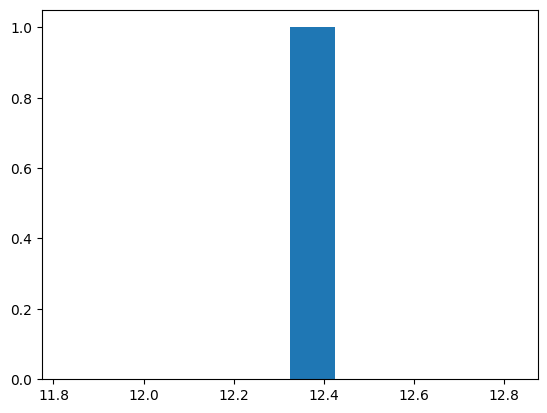

In [15]:
# XB (31/03/2023) : à virer non ? Sert à quoi ??? 

plt.hist(np.sqrt(mean_squared_error(y_test, lr_pred_test)), bins=10);

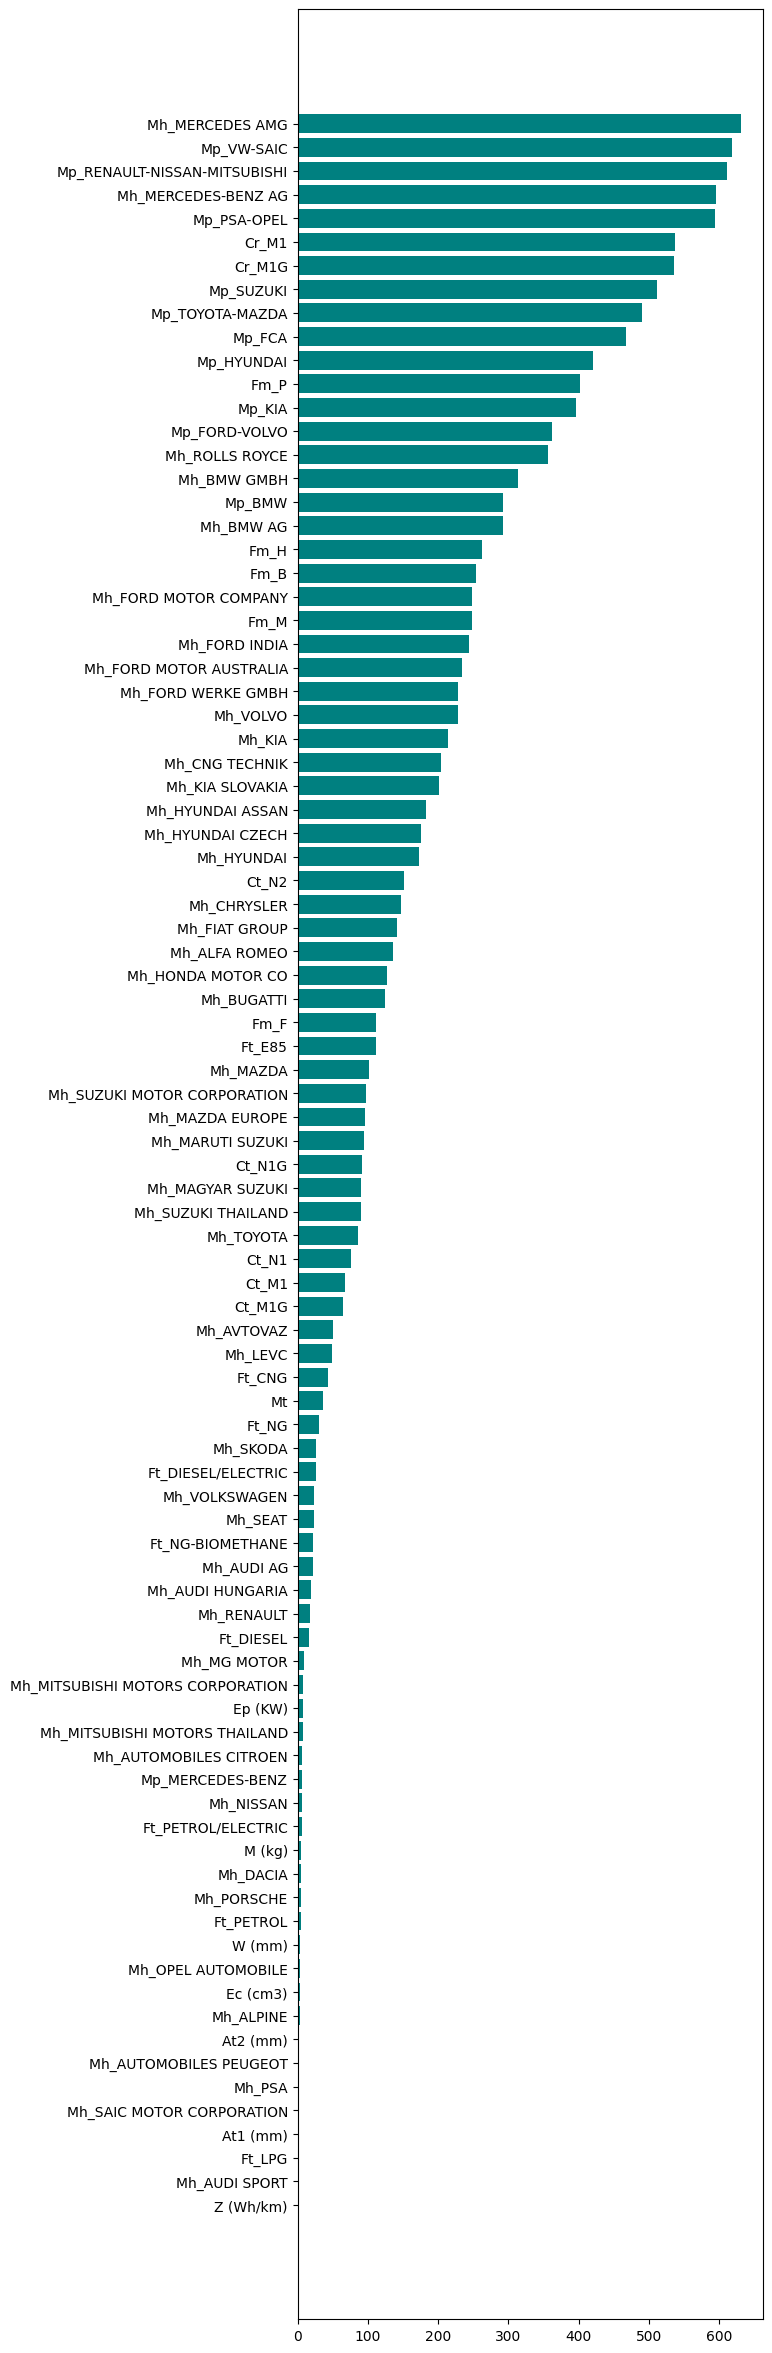

In [16]:
feature_importance = pd.Series(lr.coef_, index=X_train.columns).abs().sort_values()

plt.figure(figsize=(6, 30))
plt.barh(feature_importance.index, feature_importance.values, color='teal');

In [17]:
# Cf. Module 124 - Méthodes de régression avec scikit-learn - La Régression linéaire multiple

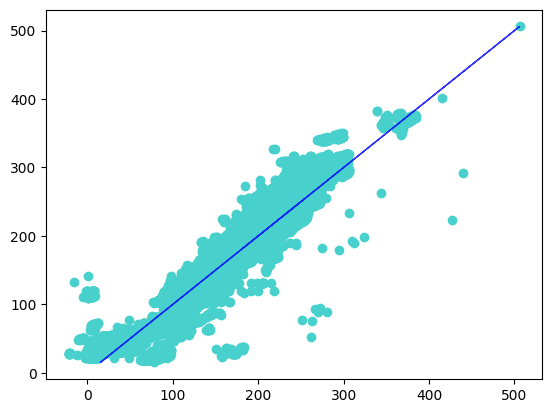

In [18]:
plt.scatter(lr_pred_test, y_test, color='mediumturquoise')
plt.plot(y_test.to_numpy(), y_test.to_numpy(), color='blue', alpha=0.8, linewidth=1)
plt.grid(False);

9.41641e-05

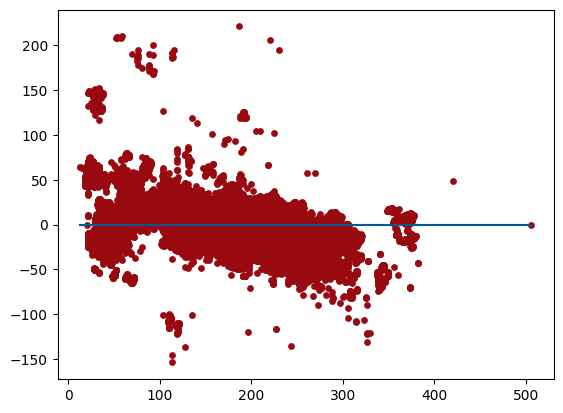

In [19]:
display(np.mean(lr_pred_train - y_train))

residus = lr_pred_train - y_train

plt.scatter(y_train, residus, color='#980a10', s=15)
plt.plot((y_train.min(), y_train.max()), (0,0), color='#0a5798');

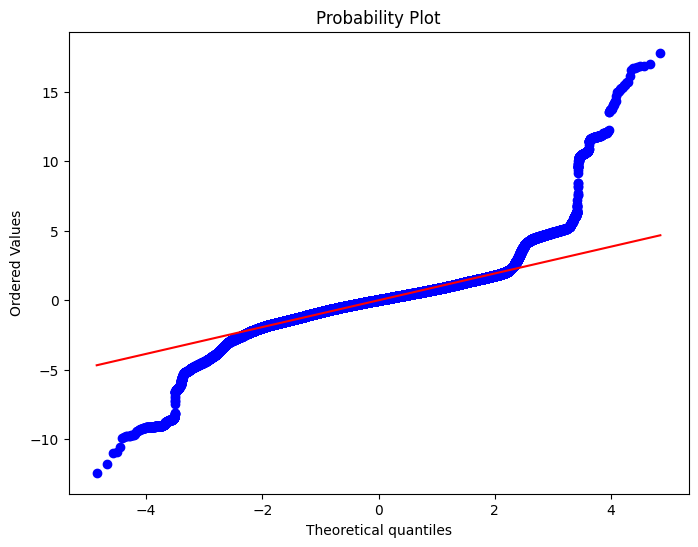

In [20]:
residus_norm = (residus-residus.mean())/residus.std()

from scipy.stats import probplot

plt.figure(figsize=(8, 6))
probplot(residus_norm, plot=plt);

In [21]:
# Affichons les variables les plus corrélées avec la variable cible.
pd.options.display.float_format = '{:20,.3f}'.format

df_corr = df.corr()
df_corr[TARGET_NAME].drop(ENEDC_EWLTP_COLNAMES).abs().sort_values(ascending=False).head(30)

Fm_P                                0.666
Ft_PETROL/ELECTRIC                  0.623
Ec (cm3)                            0.495
Z (Wh/km)                           0.476
Ep (KW)                             0.472
At1 (mm)                            0.356
At2 (mm)                            0.356
Mt                                  0.348
Fm_M                                0.326
W (mm)                              0.319
M (kg)                              0.312
Ft_DIESEL/ELECTRIC                  0.224
Ft_DIESEL                           0.221
Ct_M1                               0.192
Ct_M1G                              0.189
Cr_M1G                              0.182
Cr_M1                               0.182
Mh_PORSCHE                          0.155
Mh_AUDI SPORT                       0.135
Ft_PETROL                           0.124
Fm_H                                0.113
Mh_BMW GMBH                         0.112
Mh_MERCEDES AMG                     0.094
Mh_SKODA                          

In [24]:
signif_features = list(df_corr[TARGET_NAME].drop(ENEDC_EWLTP_COLNAMES).abs().sort_values(ascending=False).head(30).index)
print(signif_features)

['Fm_P', 'Ft_PETROL/ELECTRIC', 'Ec (cm3)', 'Z (Wh/km)', 'Ep (KW)', 'At1 (mm)', 'At2 (mm)', 'Mt', 'Fm_M', 'W (mm)', 'M (kg)', 'Ft_DIESEL/ELECTRIC', 'Ft_DIESEL', 'Ct_M1', 'Ct_M1G', 'Cr_M1G', 'Cr_M1', 'Mh_PORSCHE', 'Mh_AUDI SPORT', 'Ft_PETROL', 'Fm_H', 'Mh_BMW GMBH', 'Mh_MERCEDES AMG', 'Mh_SKODA', 'Mh_ROLLS ROYCE', 'Mp_PSA-OPEL', 'Mp_FORD-VOLVO', 'Mh_OPEL AUTOMOBILE', 'Mh_VOLKSWAGEN', 'Mp_VW-SAIC']


In [25]:
# sns.pairplot(data=df, vars=signif_features); trop LONG !!!

In [26]:
lr2 = LinearRegression().fit(X_train_sc[signif_features], y_train)

lr2_pred_train = lr2.predict(X_train_sc[signif_features])
lr2_pred_test = lr2.predict(X_test_sc[signif_features])

print(f'score train: {lr2.score(X_train_sc[signif_features], y_train)}')
print(f'rmse train : {np.sqrt(mean_squared_error(y_train, lr2_pred_train))}\n')

print(f'score test: {lr2.score(X_test_sc[signif_features], y_test)}')
print(f'rmse test : {np.sqrt(mean_squared_error(y_test, lr2_pred_test))}')

score train: 0.9098478786166343
rmse train : 13.150928497314453

score test: 0.9103064601979443
rmse test : 13.08189868927002


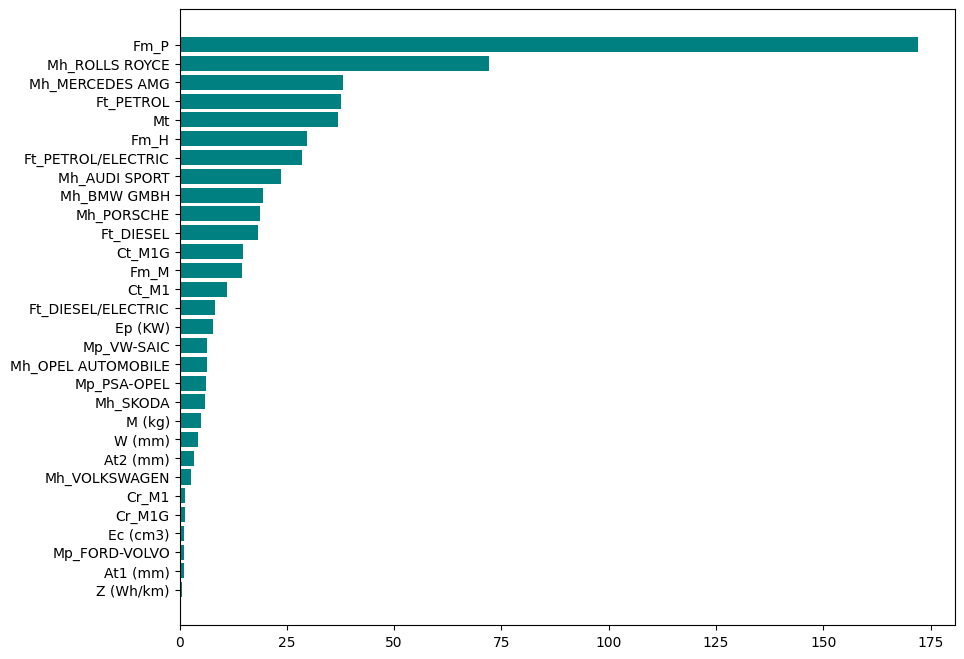

In [27]:
#importance de coef
feature_importance = pd.Series(lr2.coef_, index=signif_features).abs().sort_values()
feature_importance = feature_importance[(feature_importance != 0)]

plt.figure(figsize=(10, 8))
plt.barh(feature_importance.index, feature_importance.values, color='teal')
plt.grid(False);

In [28]:
from sklearn.feature_selection import SelectKBest, f_regression

In [29]:
sk = SelectKBest(score_func=f_regression, k=30)
sk.fit(data, target)
display(data.columns[sk.get_support()].to_list())

['M (kg)',
 'Mt',
 'W (mm)',
 'At1 (mm)',
 'At2 (mm)',
 'Ec (cm3)',
 'Ep (KW)',
 'Z (Wh/km)',
 'Mp_FORD-VOLVO',
 'Mp_PSA-OPEL',
 'Mp_VW-SAIC',
 'Mh_AUDI SPORT',
 'Mh_BMW GMBH',
 'Mh_MERCEDES AMG',
 'Mh_OPEL AUTOMOBILE',
 'Mh_PORSCHE',
 'Mh_ROLLS ROYCE',
 'Mh_SKODA',
 'Mh_VOLKSWAGEN',
 'Ct_M1',
 'Ct_M1G',
 'Cr_M1',
 'Cr_M1G',
 'Ft_DIESEL',
 'Ft_DIESEL/ELECTRIC',
 'Ft_PETROL',
 'Ft_PETROL/ELECTRIC',
 'Fm_H',
 'Fm_M',
 'Fm_P']

In [30]:
sk_train = sk.transform(X_train_sc)
sk_test = sk.transform(X_test_sc)

In [31]:
lr_sk = LinearRegression().fit(sk_train, y_train)

In [32]:
lr_sk_pred_train = lr_sk.predict(sk_train)
lr_sk_pred_test = lr_sk.predict(sk_test)

print(f'score train: {lr_sk.score(sk_train, y_train)}')
print(f'rmse train : {np.sqrt(mean_squared_error(y_train, lr_sk_pred_train))}\n')

print(f'score test: {lr_sk.score(sk_test, y_test)}')
print(f'rmse test : {np.sqrt(mean_squared_error(y_test, lr_sk_pred_test))}')

score train: 0.9098478823680157
rmse train : 13.150927543640137

score test: 0.9103064657281794
rmse test : 13.08189868927002


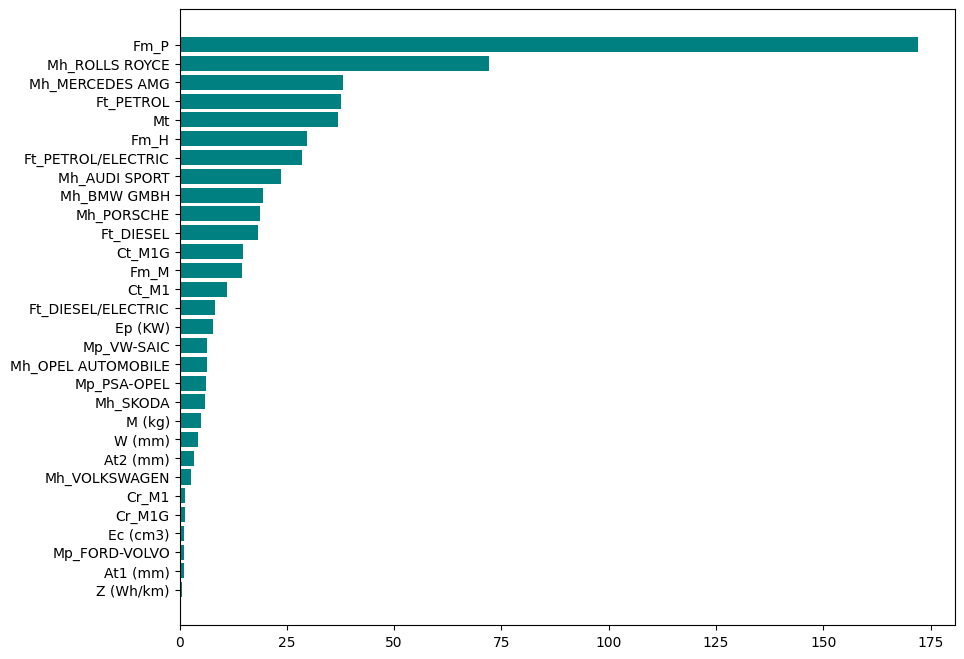

In [33]:
#importance de coef
feature_importance = pd.Series(lr_sk.coef_, data.columns[sk.get_support()].to_list()).abs().sort_values()
feature_importance = feature_importance[(feature_importance != 0)]

plt.figure(figsize=(10, 8))
plt.barh(feature_importance.index, feature_importance.values, color='teal')
plt.grid(False);

In [11]:
data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [12]:
lr_allf = LinearRegression(n_jobs=-1)

In [13]:
#X_train_sc, X_test_sc = normalize_minmax(X_train, X_test)
X_train_sc, X_test_sc = normalize_std(X_train, X_test)

In [14]:
%%time
train_scores_xf = cross_validate(lr_allf, X_train_sc, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                 cv=5, n_jobs=-1, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_xf['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_xf['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_xf['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


=========== TRAINING ===================
R-squared: 0.9164972581699795
MAE: 8.83136444091797
Fit Time: 17
Wall time: 20.5 s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.2s remaining:   30.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


In [15]:
lr_allf.fit(X_train_sc, y_train)

LinearRegression(n_jobs=-1)

In [16]:
%%time
print("============== TESTING =================== ")
print(f"R-squared: {lr_allf.score(X_test_sc, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, lr_allf.predict(X_test_sc))}")

============== TESTING =================== 
R-squared: 0.9203979870733188
MAE: 8.807266235351562
Wall time: 120 ms


In [17]:
XFEATURES = ['Fm_P', 'Ft_PETROL/ELECTRIC', 'Ec (cm3)', 'Z (Wh/km)', 'Ep (KW)', 'At1 (mm)', 'At2 (mm)', 'Mt', 'Fm_M',
             'W (mm)', 'M (kg)', 'Ft_DIESEL/ELECTRIC', 'Ft_DIESEL']

lr_xf = LinearRegression(n_jobs=-1)

In [18]:
%%time
train_scores_xf = cross_validate(lr_xf, X_train_sc[XFEATURES], y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                 cv=5, n_jobs=-1, verbose=2)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_xf['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_xf['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_xf['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s


=========== TRAINING ===================
R-squared: 0.897540838057955
MAE: 10.103111839294433
Fit Time: 0
Wall time: 1.86 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


In [19]:
lr_xf.fit(X_train_sc[XFEATURES], y_train)

LinearRegression(n_jobs=-1)

In [20]:
%%time
print("============== TESTING =================== ")
print(f"R-squared: {lr_xf.score(X_test_sc[XFEATURES], y_test)}")
print(f"MAE: {mean_absolute_error(y_test, lr_xf.predict(X_test_sc[XFEATURES]))}")

============== TESTING =================== 
R-squared: 0.8981559203499454
MAE: 10.070660591125488
Wall time: 40 ms


## 6.2 Régression linéaire polynomiale

In [21]:
from sklearn.model_selection import cross_val_score

cols = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Ft_DIESEL', 'Ft_LPG', 'Ft_PETROL']

sc = StandardScaler().fit(data[cols])
data_std = sc.transform(data[cols])

In [23]:
# Meilleurs scores obtenus avec un polynôme de degré 1
poly:PolynomialFeatures = PolynomialFeatures(degree=1)
    
poly_train_sc = X_train_sc[cols]
poly_test_sc = X_test_sc[cols]

poly_train = poly.fit_transform(poly_train_sc)
poly_test = poly.transform(poly_test_sc)

lr = LinearRegression(n_jobs=-1)
lr.fit(poly_train, y_train)

poly_pred_train = lr.predict(poly_train)
poly_pred_test = lr.predict(poly_test)


print(f'score train: {lr.score(poly_train, y_train)}')
print(f'rmse train : {np.sqrt(mean_squared_error(y_train, poly_pred_train))}\n')

print(f'score test: {lr.score(poly_test, y_test)}')
print(f'rmse test : {np.sqrt(mean_squared_error(y_test, poly_pred_test))}')

score train: 0.8529629287228564
rmse train : 16.79507064819336

score test: 0.854738267663893
rmse test : 16.648141860961914


In [24]:
XFEATURES = ['Fm_P', 'Ft_PETROL/ELECTRIC', 'Ec (cm3)', 'Z (Wh/km)', 'Ep (KW)', 'At1 (mm)', 'At2 (mm)', 'Mt', 'Fm_M',
             'W (mm)', 'M (kg)', 'Ft_DIESEL/ELECTRIC', 'Ft_DIESEL']

lr_xf = LinearRegression(n_jobs=-1)

In [25]:
poly:PolynomialFeatures = PolynomialFeatures(degree=1)
    
poly_train_sc = X_train_sc[XFEATURES]
poly_test_sc = X_test_sc[XFEATURES]

poly_train = poly.fit_transform(poly_train_sc)
poly_test = poly.transform(poly_test_sc)

In [26]:
%%time
train_scores_xf = cross_validate(lr_xf, poly_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                 cv=5, n_jobs=-1, verbose=0)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_xf['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_xf['test_neg_mean_absolute_error'].mean())}")
print(f"Total Time: {(train_scores_xf['fit_time'].mean() + train_scores_xf['score_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.8975408403290726
MAE: 10.10311222076416
Total Time: 1
Wall time: 1.02 s


In [27]:
%%time
test_scores_xf = cross_validate(lr_xf, poly_test, y_test, scoring=['r2', 'neg_mean_absolute_error'], 
                                cv=5, n_jobs=-1, verbose=0)
print("========== TESTING ====================")
print(f"R-squared: {test_scores_xf['test_r2'].mean()}")
print(f"MAE: {np.abs(test_scores_xf['test_neg_mean_absolute_error'].mean())}")
print(f"Total Time: {(test_scores_xf['fit_time'].mean() + test_scores_xf['score_time'].mean()).round():.0f}")

========== TESTING ====================
R-squared: 0.8981411086427042
MAE: 10.058399963378907
Total Time: 0
Wall time: 359 ms


In [64]:
# Meilleurs scores obtenus avec un polynôme de degré 2
poly:PolynomialFeatures = PolynomialFeatures(degree=2)

cols = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Ft_DIESEL', 'Ft_LPG', 'Ft_PETROL']

poly_train_sc = X_train_sc[cols]
poly_test_sc = X_test_sc[cols]

poly_train = poly.fit_transform(poly_train_sc)
poly_test = poly.transform(poly_test_sc)
lr.fit(poly_train, y_train)

poly_pred_train = lr.predict(poly_train)
poly_pred_test = lr.predict(poly_test)

print(f'score train: {lr.score(poly_train, y_train)}')
print(f'rmse train : {np.sqrt(mean_squared_error(y_train, poly_pred_train))}\n')

print(f'score test: {lr.score(poly_test, y_test)}')
print(f'rmse test : {np.sqrt(mean_squared_error(y_test, poly_pred_test))}')

score train: 0.9162730007726787
rmse train : 12.67363452911377

score test: 0.9176078175492262
rmse test : 12.538142204284668


In [65]:
# Meilleurs scores obtenus avec un polynôme de degré 3
poly:PolynomialFeatures = PolynomialFeatures(degree=3)

cols = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Ft_DIESEL', 'Ft_LPG', 'Ft_PETROL']

poly_train_sc = X_train_sc[cols]
poly_test_sc = X_test_sc[cols]

poly_train = poly.fit_transform(poly_train_sc)
poly_test = poly.transform(poly_test_sc)
lr.fit(poly_train, y_train)

poly_pred_train = lr.predict(poly_train)
poly_pred_test = lr.predict(poly_test)

print(f'score train: {lr.score(poly_train, y_train)}')
print(f'rmse train : {np.sqrt(mean_squared_error(y_train, poly_pred_train))}\n')

print(f'score test: {lr.score(poly_test, y_test)}')
print(f'rmse test : {np.sqrt(mean_squared_error(y_test, poly_pred_test))}')

score train: 0.9362461630562711
rmse train : 11.059144020080566

score test: 0.9367981514528712
rmse test : 10.981332778930664


In [47]:
# Meilleurs scores obtenus avec un polynôme de degré 4
poly:PolynomialFeatures = PolynomialFeatures(degree=4)

cols = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Ft_DIESEL', 'Ft_LPG', 'Ft_PETROL']

poly_train_sc = X_train_sc[cols]
poly_test_sc = X_test_sc[cols]

poly_train = poly.fit_transform(poly_train_sc)
poly_test = poly.transform(poly_test_sc)
lr.fit(poly_train, y_train)

poly_pred_train = lr.predict(poly_train)
poly_pred_test = lr.predict(poly_test)

print(f'score train: {lr.score(poly_train, y_train)}')
print(f'rmse train : {np.sqrt(mean_squared_error(y_train, poly_pred_train))}\n')

print(f'score test: {lr.score(poly_test, y_test)}')
print(f'rmse test : {np.sqrt(mean_squared_error(y_test, poly_pred_test))}')

score train: 0.9404755718579656
rmse train : 10.686020851135254

score test: 0.8007208073307387
rmse test : 19.4993953704834


In [72]:
from sklearn.model_selection import cross_val_score

cols = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Ft_DIESEL', 'Ft_LPG', 'Ft_PETROL']

sc = StandardScaler().fit(data[cols])
data_std = sc.transform(data[cols])

lr = LinearRegression(n_jobs=-1)

In [74]:
poly:PolynomialFeatures = PolynomialFeatures(degree=1)

poly_train = poly.fit_transform(data_std)
scores = cross_val_score(lr, poly_train, target, cv=3, n_jobs=-1)
lr.fit(poly_train, target)
poly_pred_train = lr.predict(poly_train)
print('Score CV régression polynomiale :', scores.mean())

Score CV régression polynomiale : 0.8490424199202021


In [75]:
poly:PolynomialFeatures = PolynomialFeatures(degree=2)

poly_train = poly.fit_transform(data_std)
scores = cross_val_score(lr, poly_train, target, cv=3)
lr.fit(poly_train, target)
poly_pred_train = lr.predict(poly_train)
print('Score CV régression polynomiale :',scores.mean())

Score CV régression polynomiale : 0.9116537906299035


In [76]:
poly:PolynomialFeatures = PolynomialFeatures(degree=3)

poly_train = poly.fit_transform(data_std)
scores = cross_val_score(lr, poly_train, target, cv=3)
lr.fit(poly_train, target)
poly_pred_train = lr.predict(poly_train)
print('Score CV régression polynomiale :',scores.mean())

Score CV régression polynomiale : 0.9277097954596014


In [51]:
#poly:PolynomialFeatures = PolynomialFeatures(degree=4)
#poly_train = poly.fit_transform(data_std)
#scores = cross_val_score(lr, poly_train, target, cv=3)
#lr.fit(poly_train, target)
#poly_pred_train = lr.predict(poly_train)
#print('Score CV régression polynomiale :',scores.mean())

In [52]:
cols = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)']
datad2 = df[df['Ft_DIESEL']==1][cols]
targetd2 = df[df['Ft_DIESEL']==1][TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(datad2, targetd2, test_size=TEST_SIZE, random_state=RANDOM_STATE)

poly_train_sc, poly_test_sc = normalize_std(X_train, X_test, cols)
# poly_train_sc, poly_test_sc = normalize_minmax(X_train, X_test)

poly_train = poly.fit_transform(poly_train_sc)
poly_test = poly.transform(poly_test_sc)
lr.fit(poly_train, y_train)

print(f"Score sur l'ensemble de test: {lr.score(poly_test, y_test)}.")

Score sur l'ensemble de test: 0.8849781064926384.


In [53]:
cols = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)']
datap = df[df['Ft_PETROL']==1][cols]
targetp = df[df['Ft_PETROL']==1][TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(datap, targetp, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# X_train_sc, X_test_sc = normalize_minmax(X_train, X_test)
poly_train_sc, poly_test_sc = normalize_std(X_train, X_test, cols)

poly_train = poly.fit_transform(poly_train_sc)
poly_test = poly.transform(poly_test_sc)
lr.fit(poly_train, y_train)

print(f"Score sur l'ensemble de test: {lr.score(poly_test, y_test)}.")

Score sur l'ensemble de test: 0.874450541184864.


## 6.3 Ridge

In [54]:
%%time
ridge_reg = RidgeCV(alphas=(0.0001, 0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Nécessité de standardizer pour Ridge ou Lasso
X_train_sc, X_test_sc = normalize_std(X_train, X_test)

ridge_reg.fit(X_train_sc, y_train) 

print('alpha sélectionné par validation croisée :', ridge_reg.alpha_)
 
print('score train :', ridge_reg.score(X_train_sc, y_train))
print(f"MSE Train : {np.sqrt(mean_squared_error(ridge_reg.predict(X_train_sc), y_train))}\n")

print('score test :', ridge_reg.score(X_test_sc, y_test))
print(f"MSE Test : {np.sqrt(mean_squared_error(ridge_reg.predict(X_test_sc), y_test))}")

alpha sélectionné par validation croisée : 0.3
score train : 0.9198346290270144
MSE Train : 12.40114519710892

score test : 0.920396304763266
MSE Test : 12.32414467429603
Wall time: 13.4 s


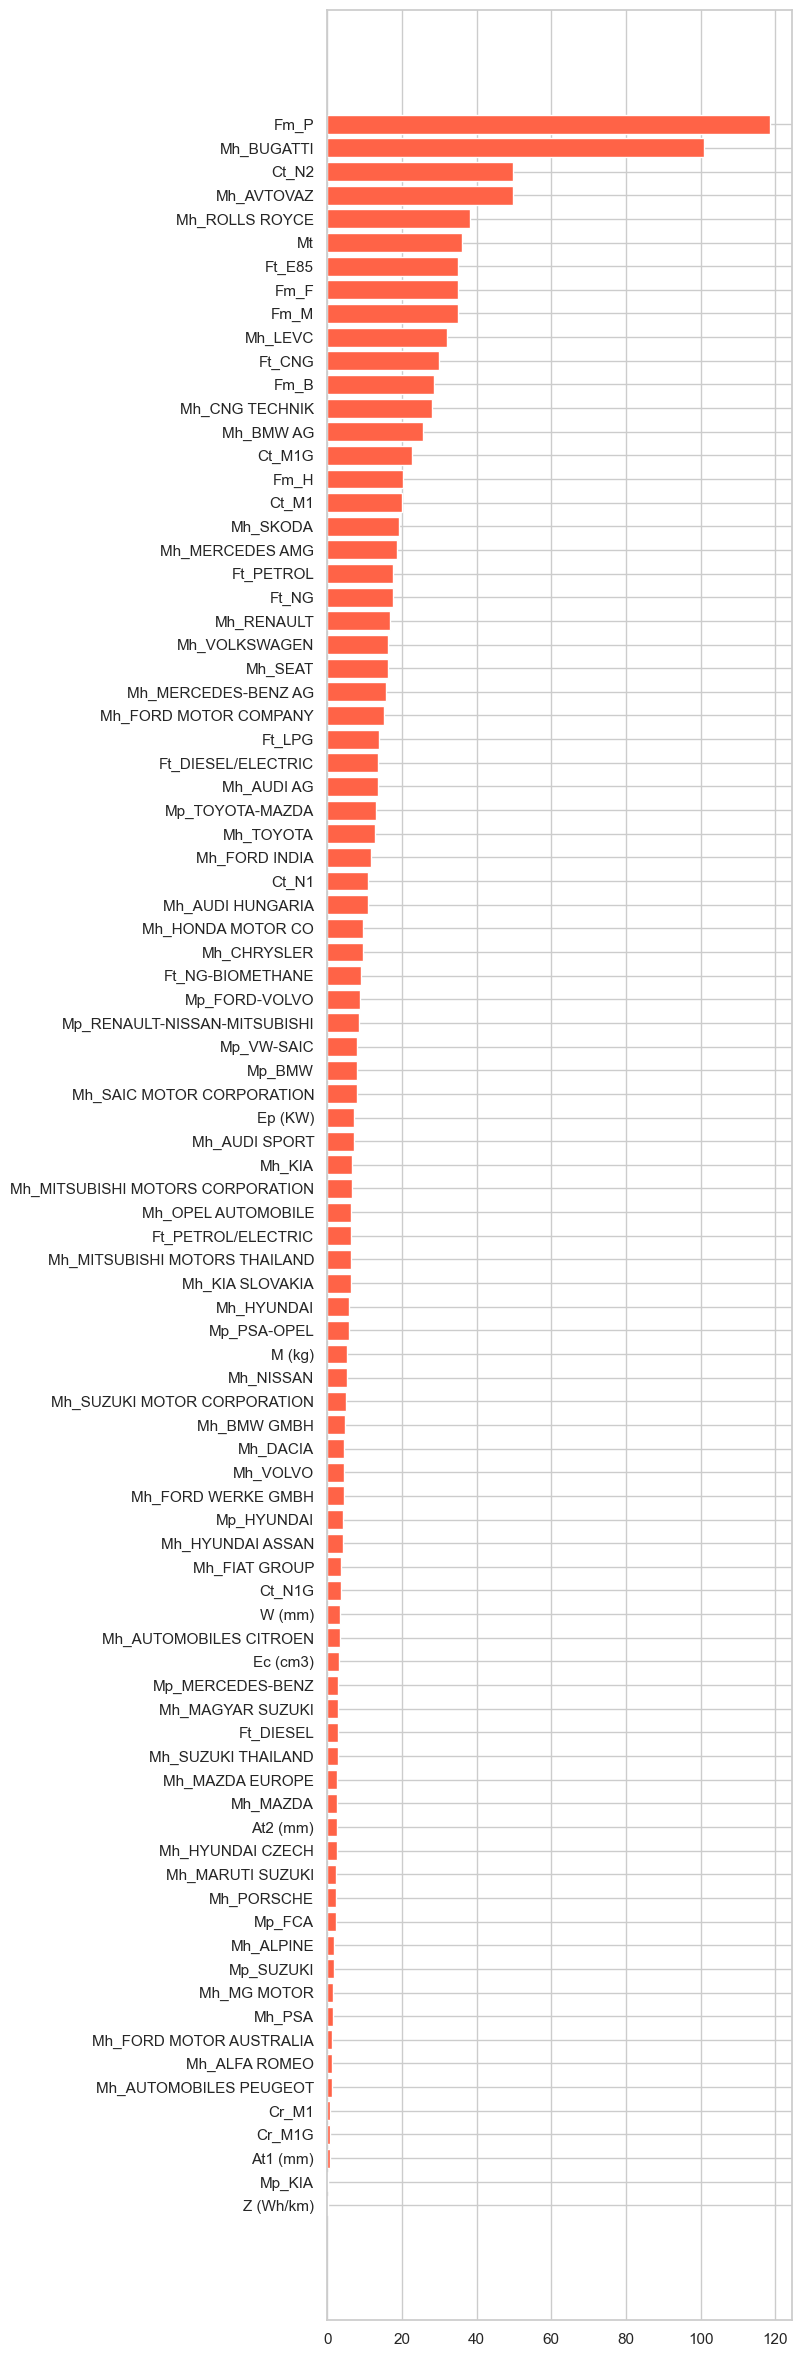

In [55]:
feature_importance = pd.Series(ridge_reg.coef_, index=X_train.columns).abs().sort_values()

plt.figure(figsize=(6, 30))
plt.barh(feature_importance.index, feature_importance.values, color='tomato');

## 6.4 ElasticNet

Avec toutes les variables :

In [56]:
from sklearn.linear_model import ElasticNetCV

In [57]:
X_train_sc, X_test_sc = normalize_std(X_train, X_test)

In [58]:
%%time
model_en = ElasticNetCV(cv=3, l1_ratio=(0.0001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.75,.9999), 
                        alphas=(0.0001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.75,1.0),
                        n_jobs=-1)

#model_en = ElasticNetCV(cv=3, l1_ratio=(0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1), 
#                        alphas=(0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1), 
#                        n_jobs=-1)

#model_en = ElasticNetCV(cv=3, l1_ratio=(0.0001, 0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, .9999), 
#                        alphas=(0.0001, 0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, .9999, 1.0), 
#                        n_jobs=-1)

model_en.fit(X_train_sc, y_train)

C:\Users\aupee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56672688.0, tolerance: 141952.71875
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\aupee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66892988.0, tolerance: 141873.9375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\aupee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37376620.0, tolerance: 141952.71875
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\aupee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not c

Wall time: 1min 3s


C:\Users\aupee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.642e+07, tolerance: 2.128e+05
  model = cd_fast.enet_coordinate_descent(


ElasticNetCV(alphas=(0.0001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0), cv=3,
             l1_ratio=(0.0001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9999),
             n_jobs=-1)

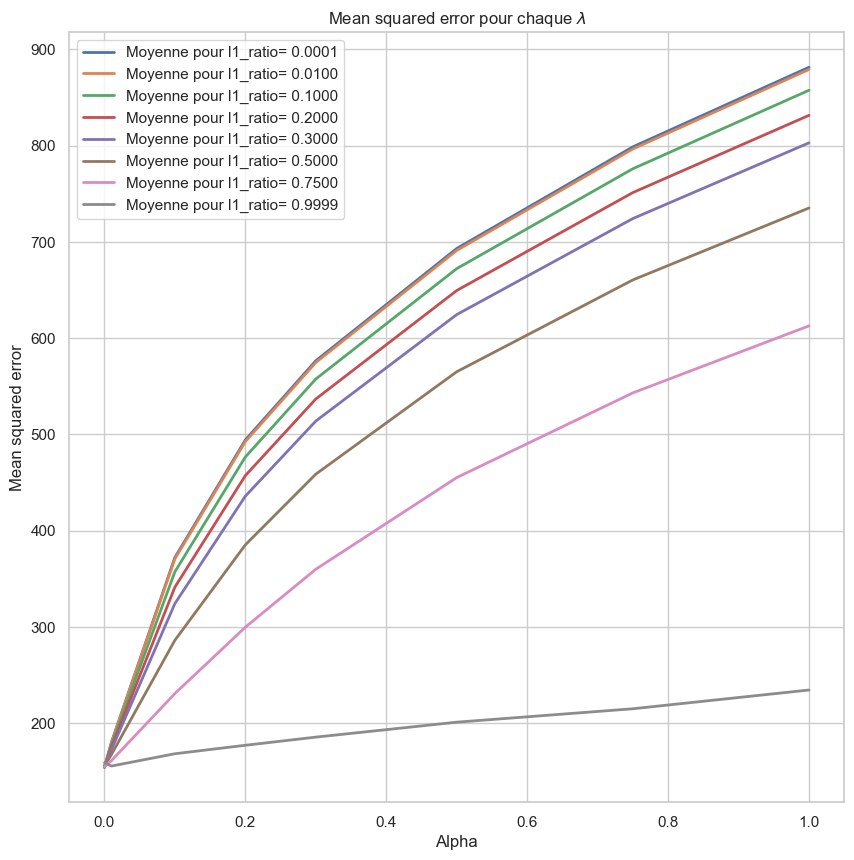

In [59]:
alphas = model_en.alphas_

plt.figure(figsize=(10, 10))

for i in range(model_en.mse_path_.shape[0]):
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1), label='Moyenne pour l1_ratio= %.4f' %model_en.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque $\lambda$')
plt.legend();

In [60]:
%%time
en_pred_train = model_en.predict(X_train_sc)
en_pred_test = model_en.predict(X_test_sc)

print(f"score train : {model_en.score(X_train_sc, y_train)}")
print(f"rmse train : {np.sqrt(mean_squared_error(y_train, en_pred_train))}\n")

print(f"score test : {model_en.score(X_test_sc, y_test)}")
print(f'rmse test : {np.sqrt(mean_squared_error(y_test, en_pred_test))}')

print(model_en.alpha_)

score train : 0.9197332247958332
rmse train : 12.40898609161377

score test : 0.9202633852939417
rmse test : 12.334429740905762
0.0001
Wall time: 535 ms


## 6.5 Lasso

In [61]:
# Nécessité de standardizer pour Ridge ou Lasso
X_train_sc, X_test_sc = normalize_std(X_train, X_test)

In [62]:
from sklearn.linear_model import Lasso

lasso_r = Lasso(alpha=1.0).fit(X_train_sc, y_train)

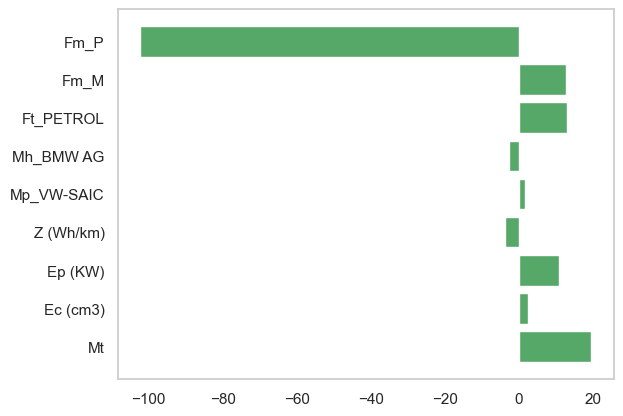

In [63]:
coefs:pd.Series = pd.Series(data=list(lasso_r.coef_), index=data.columns)
coefs = coefs[(coefs != 0)]

plt.grid(False)
plt.barh(coefs.index, coefs.values, color='g');

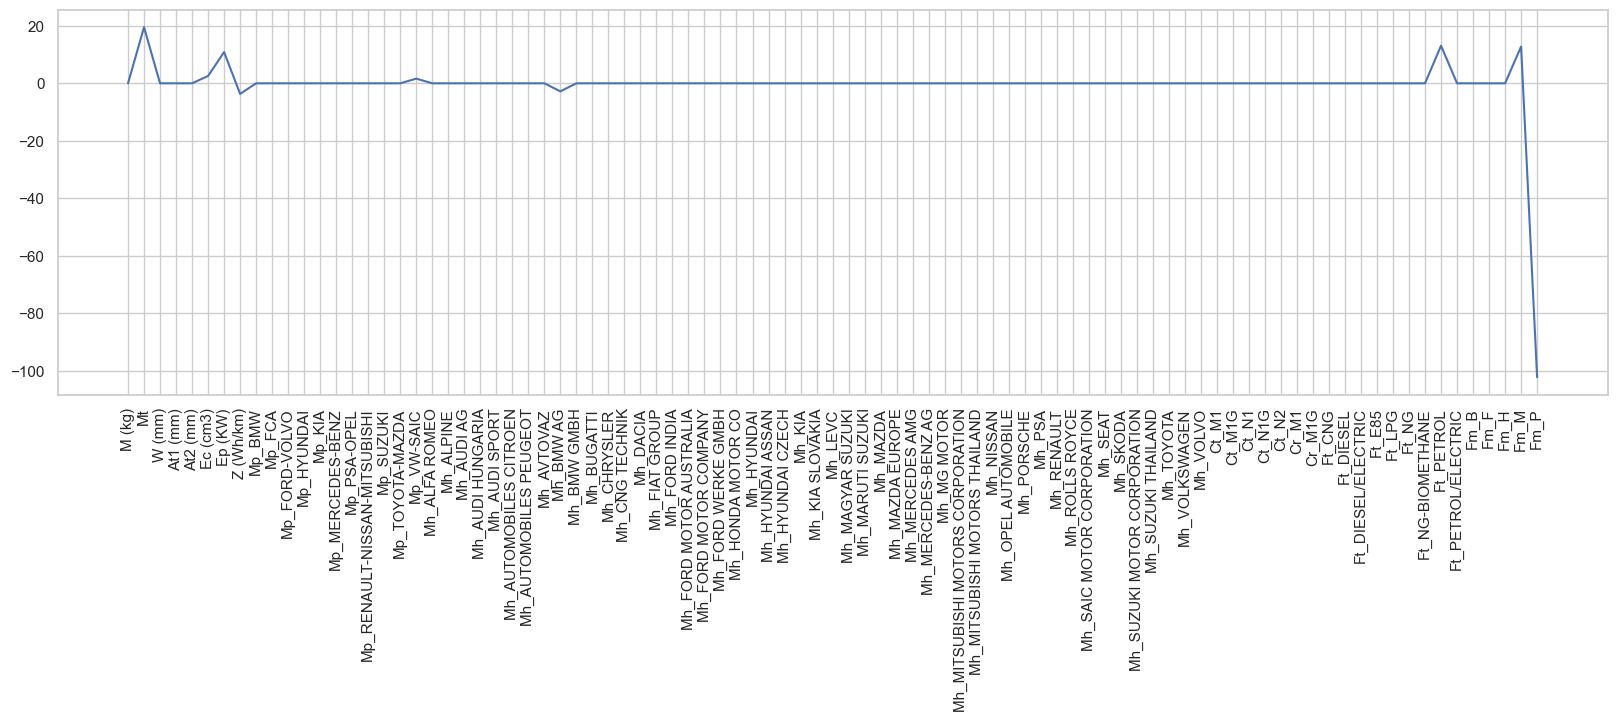

In [64]:
lasso_coef = lasso_r.coef_

plt.figure(figsize=(20, 5))
plt.plot(range(len(data.columns)), lasso_coef)
plt.xticks(range(len(data.columns)), data.columns.values, rotation=90);

In [65]:
lasso_pred_train = lasso_r.predict(X_train_sc)
lasso_pred_test = lasso_r.predict(X_test_sc)

print(f"score train : {lasso_r.score(X_train_sc, y_train)}")
print(f"rmse train : {np.sqrt(mean_squared_error(y_train, lasso_pred_train))}\n")

print(f"score test : {lasso_r.score(X_test_sc, y_test)}")
print(f'rmse test : {np.sqrt(mean_squared_error(y_test, lasso_pred_test))}')

score train : 0.8779215365314715
rmse train : 15.303398132324219

score test : 0.8784521371880984
rmse test : 15.228734016418457


In [66]:
from sklearn.linear_model import lasso_path

mes_alphas = [0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0]
alpha_path, coefs_lasso, _ = lasso_path(X_train_sc, y_train, alphas=mes_alphas)

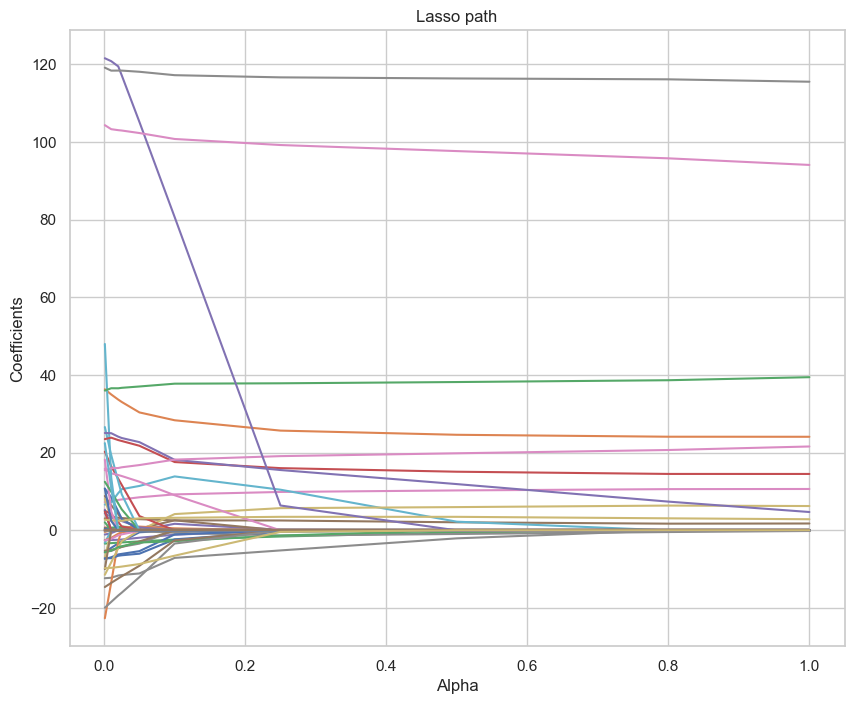

In [67]:
plt.figure(figsize=(10, 8))
for i in range(coefs_lasso.shape[0]):
    plt.plot(alpha_path, coefs_lasso[i, :])

plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path');

In [68]:
%%time

from sklearn.linear_model import LassoCV

model_lasso = LassoCV(cv=10).fit(X_train_sc, y_train)
alphas = model_lasso.alphas_

Wall time: 41 s


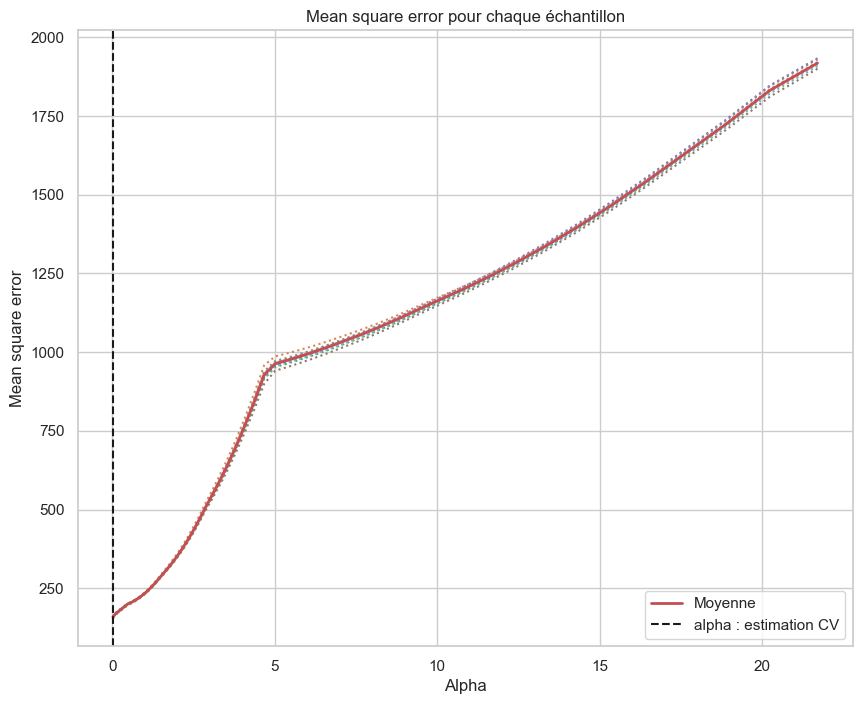

In [69]:
plt.figure(figsize = (10, 8))
plt.plot(alphas, model_lasso.mse_path_, ":")
plt.plot(alphas, model_lasso.mse_path_.mean(axis=1), color='r', label='Moyenne', lw=2)
plt.axvline(model_lasso.alpha_, linestyle='--', color='k', label='alpha : estimation CV')

plt.xlabel('Alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error pour chaque échantillon')
plt.legend();

In [70]:
lasso_pred_test = model_lasso.predict(X_test_sc)

print(f"Score R2 : {model_lasso.score(X_test_sc, y_test):.5f}")
print(f"MSE : {mean_squared_error(y_test, lasso_pred_test):.5f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, lasso_pred_test)):.5f}")

Score R2 : 0.91785
MSE : 156.74054
RMSE : 12.51961


## 6.6 Régression polynomiale : 2ème essai

In [71]:
features = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Ft_DIESEL', 'Ft_LPG', 'Ft_PETROL']

X, y = data[features], target
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [72]:
X_train_sc, X_test_sc = normalize_minmax(X_train, X_test)

In [73]:
poly_reg_model = LinearRegression().fit(X_train_sc, y_train)

In [74]:
poly_reg_pred_train = poly_reg_model.predict(X_train_sc)
poly_reg_pred_test = poly_reg_model.predict(X_test_sc)

print(f'score train: {poly_reg_model.score(X_train_sc, y_train)}')
print(f'rmse train : {np.sqrt(mean_squared_error(y_train, poly_reg_pred_train))}\n')

print(f'score test: {poly_reg_model.score(X_test_sc, y_test)}')
print(f'rmse test : {np.sqrt(mean_squared_error(y_test, poly_reg_pred_test))}')

score train: 0.9360126889086321
rmse train : 11.079376220703125

score test: 0.9365539071092948
rmse test : 11.002532005310059


## 6.7 SVR

### [BEGIN] XB - 02/04/2023

In [ ]:
Cf. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
The implementation is based on libsvm. 
The fit time complexity is more than quadratic with the number of samples 
which makes it hard to scale to datasets with more than a couple of 10 000 samples. 

For large datasets consider using LinearSVR or SGDRegressor instead, 
possibly after a Nystroem transformer or other Kernel Approximation.

In [12]:
from sklearn.svm import SVR, LinearSVR

#### Réduction de dimension à 10 variables

In [13]:
XFEATURES = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Z (Wh/km)', 
             'Fm_P', 'Ft_PETROL/ELECTRIC']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[XFEATURES], target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train_sc, X_test_sc = normalize_minmax(X_train, X_test)

In [14]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [15]:
lsvr = LinearSVR(verbose=2, random_state=RANDOM_STATE, max_iter=1000)

In [26]:
%%time
param_grid = {'C':[0.05,0.1,0.15,0.2], 'epsilon':[0.0015,0.002,0.0025,0.025,0.0004]}
halving_cv = HalvingGridSearchCV(lsvr,
                                 param_grid=param_grid,
                                 factor=2,
                                 scoring='r2',
                                 random_state=RANDOM_STATE,
                                 n_jobs=-1,
                                 verbose=2)

halving_cv.fit(X_train_sc, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 123269
max_resources_: 1109429
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 123269
Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Typhaon\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
C:\Users\Typhaon\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


----------
iter: 1
n_candidates: 7
n_resources: 369807
Fitting 5 folds for each of 7 candidates, totalling 35 fits


C:\Users\Typhaon\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\Typhaon\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


----------
iter: 2
n_candidates: 3
n_resources: 1109421
Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\Typhaon\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\Typhaon\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


[LibLinear]CPU times: total: 13.4 s
Wall time: 1min 33s


HalvingGridSearchCV(estimator=LinearSVR(max_iter=100, random_state=1492,
                                        verbose=2),
                    n_jobs=-1,
                    param_grid={'C': [0.05, 0.1, 0.15, 0.2],
                                'epsilon': [0.0015, 0.002, 0.0025, 0.025,
                                            0.0004]},
                    random_state=1492, scoring='precision', verbose=2)

In [27]:
print(halving_cv.best_estimator_)

LinearSVR(C=0.05, epsilon=0.002, max_iter=100, random_state=1492, verbose=2)


In [28]:
halving_cv.best_params_

{'C': 0.05, 'epsilon': 0.002}

In [ ]:
# %%time
# train_scores_lsvr = cross_validate(lsvr, X_train_sc, y_train, scoring=['r2', 'neg_mean_absolute_error'],
#                                    cv=5, n_jobs=5, verbose=1)
# print("=========== TRAINING ===================")
# print(f"R-squared: {train_scores_lsvr['test_r2'].mean()}")
# print(f"MAE: {np.abs(train_scores_lsvr['test_neg_mean_absolute_error'].mean())}")
# print(f"Fit Time: {(train_scores_xf['fit_time'].mean()).round():.0f}")

In [20]:
%%time
lsvr.fit(X_train_sc, y_train)

[LibLinear]CPU times: total: 10.1 s
Wall time: 10.2 s


LinearSVR(max_iter=100, random_state=1492, verbose=2)

In [21]:
%%time
print("=========== TESTING ================")
print(f"R-squared: {lsvr.score(X_test_sc, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, lsvr.predict(X_test_sc))}")

=========== TESTING ================
R-squared: 0.8615197511299446
MAE: 11.80366595752608
CPU times: total: 188 ms
Wall time: 163 ms


In [30]:
base_lsvr = LinearSVR(**halving_cv.best_params_, verbose=2, random_state=RANDOM_STATE, max_iter=1000)

In [ ]:
%%time
train_scores = cross_validate(base_lsvr, X_train_sc, y_train, scoring=['r2', 'neg_mean_absolute_error'],
                              cv=5, n_jobs=5, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_af['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_af['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_af['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [ ]:
%%time
base_lsvr.fit(X_train_sc, y_train)

In [ ]:
%%time
print("=========== TESTING ================")
print(f"R-squared: {base_lsvr.score(X_test_sc, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, base_lsvr.predict(X_test_sc))}")

## 6.8 Ramdom Forest Classifier

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

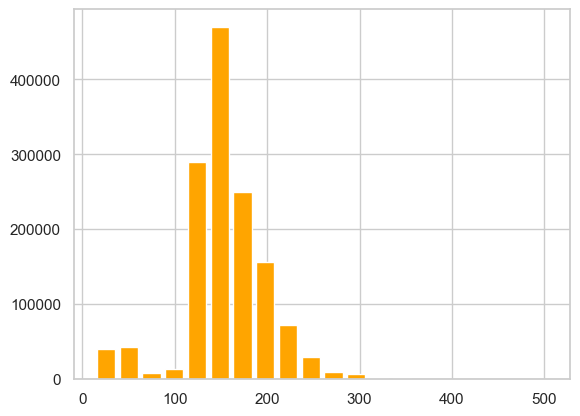

In [77]:
plt.hist(target,  bins=20, color='orange', rwidth=0.8)
plt.show()
#rappel de la distribution de notre target

In [78]:
#dichotomiser les variables
target_dich = pd.cut(x = target,
                  bins = [0, 30, 50, 70, 90, 110, 130, 150, 170, 190,210,230,250,270, 290, 310, 370, 410, 550],
                  labels = [15, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 340, 380, 450])

X_train, X_test, y_train, y_test = train_test_split(data, target_dich, test_size = 0.2,random_state = 12)

In [79]:

clf = RandomForestClassifier(n_jobs=-1, random_state=321)
#clf = RandomForestClassifier(n_jobs = -1)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)


0.8820657778034166

In [80]:
y_pred = clf.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,15,40,60,80,100,120,140,160,180,200,220,240,260,280,300,340,380
Classe réelle,,,,,,,,,,,,,,,,,
15,2960,223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40,218,8854,236,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60,0,225,4337,23,1,0,0,0,0,0,0,0,0,0,0,0,0
80,0,0,21,1169,31,1,0,0,0,0,0,0,0,0,0,0,0
100,0,0,1,43,1657,175,0,0,0,0,0,0,0,0,0,0,0
120,0,0,0,0,201,31612,3134,1,0,0,0,0,0,0,0,0,0
140,0,0,0,0,0,3170,71950,5489,3,0,0,0,0,0,0,0,0
160,0,0,0,0,0,5,5574,54433,2892,9,0,0,0,0,0,0,0
180,0,0,0,0,0,0,5,3186,26133,1819,2,0,0,0,0,0,0


Cela pourrait apporter un complément mais les résultats ne sont pas assez bons.


## 6.9 Random Forest Regressor

In [11]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from time import time
from sklearn.model_selection import cross_val_score

In [12]:
#1er test
regressor = RandomForestRegressor(n_estimators=10, random_state=0)
regressor.fit(X_train_sc, y_train)
print(regressor.score(X_test_sc, y_test))

0.9938206692584378


In [53]:
#2ème test

rf = RandomForestRegressor(n_estimators = 10, random_state = 0)
scores = cross_val_score(rf, X_train_sc, y_train, cv=5)
scores

array([0.99378559, 0.99385791, 0.99355605, 0.99361379, 0.99375008])

In [17]:
n_estimators_list = [1,4,7,10,15,20]

for i in n_estimators_list:
    t0 = time()
    print("nombre d'estimateurs : ",i)
    
    rf = RandomForestRegressor(n_estimators = i)
    scores_train = cross_val_score(rf, X_train_sc, y_train, cv=5)
    
    print('score train : ',scores_train.mean())
    print("score train réalisé en {} secondes".format(round(t1,3)))
    t1 = time() - t0
    
    t0 = time()
    rf.fit(X_train_sc, y_train)
    print('score test : ',rf.score(X_test_sc, y_test))
    print("score test réalisé en {} secondes".format(round(t1,3)))
    t1 = time() - t0

nombre d'estimateurs :  1
score train :  0.9917788803886551
score train réalisé en 40.952 secondes
score test :  0.9921706489173324
score test réalisé en 40.505 secondes
nombre d'estimateurs :  4
score train :  0.9933515967635941
score train réalisé en 9.952 secondes
score test :  0.9935663601821125
score test réalisé en 154.541 secondes
nombre d'estimateurs :  7
score train :  0.9935671845184858
score train réalisé en 40.688 secondes
score test :  0.993778695898144
score test réalisé en 266.801 secondes
nombre d'estimateurs :  10
score train :  0.9936749411112057
score train réalisé en 69.554 secondes
score test :  0.9938311457885011
score test réalisé en 383.806 secondes
nombre d'estimateurs :  15
score train :  0.9937304587521932
score train réalisé en 99.831 secondes
score test :  0.9939424333728017
score test réalisé en 572.374 secondes
nombre d'estimateurs :  20
score train :  0.9937857921828519
score train réalisé en 146.292 secondes
score test :  0.9939532927223164
score test r

In [28]:
scores_list =[]
max_depth_list = [3,5,7,10,15]

t0 = time()
for i in max_depth_list:
    
    rf = RandomForestRegressor(n_estimators = 20, max_depth = i)
    scores = cross_val_score(rf, X_train_sc, y_train, cv=5)
    t1 = time() - t0
    print("Réalisé en {} secondes".format(round(t1,3)))
    scores_list.append(scores.mean())
    print(scores.mean())

Réalisé en 92.804 secondes
0.7913346189149926
Réalisé en 239.503 secondes
0.889238325647038
Réalisé en 438.496 secondes
0.9352090908434446
Réalisé en 696.082 secondes
0.9724371072853124
Réalisé en 1008.744 secondes
0.9902377852610874


Pas d'amélioration notable au delà de 4 pour le nombre d'estimateurs mais une limitation de la profondeur max a un impact négatif significatif.

### [BEGIN] XB - 31/03/2023

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
RANDOM_STATE = 1492
TEST_SIZE = .2

In [14]:
data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [15]:
base_rfr = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)

In [16]:
%%time
train_scores_af = cross_validate(base_rfr, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                 cv=5, n_jobs=-1, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_af['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_af['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_af['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.3min


=========== TRAINING ===================
R-squared: 0.9938207120009898
MAE: 2.261622708465688
Fit Time: 288
Wall time: 4min 54s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


In [17]:
base_rfr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.3min finished


RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=1492, verbose=1)

In [18]:
%%time
print("=========== TESTING ================")
print(f"R-squared: {base_rfr.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, base_rfr.predict(X_test))}")

=========== TESTING ================


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


R-squared: 0.9938637417709615
MAE: 2.2529557251923475
Wall time: 1.58 s


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.6s finished


In [19]:
tuned_rfr = RandomForestRegressor(n_estimators=25, min_samples_split=4, max_features=5, 
                                  n_jobs=-1, random_state=RANDOM_STATE, verbose=1)

In [23]:
%%time
train_scores_xf = cross_validate(tuned_rfr, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                 cv=5, n_jobs=-1, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_xf['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_xf['test_neg_mean_absolute_error'].mean())}")
print(f"Total Time: {(train_scores_xf['fit_time'].mean() + train_scores_xf['score_time'].mean()).round():.0f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.3min


=========== TRAINING ===================
R-squared: 0.9940003193358287
MAE: 2.261944965779344
Total Time: 91
Wall time: 1min 36s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


In [24]:
%%time
tuned_rfr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Wall time: 23.7 s


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   23.4s finished


RandomForestRegressor(max_features=5, min_samples_split=4, n_estimators=25,
                      n_jobs=-1, random_state=1492, verbose=1)

In [25]:
%%time
print("=========== TESTING ================")
print(f"R-squared: {tuned_rfr.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, tuned_rfr.predict(X_test))}")

=========== TESTING ================


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


R-squared: 0.9940255406694141
MAE: 2.252551147508472
Wall time: 2.1 s


[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.9s finished


#### Réduction de dimension

#### 10 variables

In [30]:
XFEATURES = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 
             'Ft_DIESEL', 'Ft_LPG', 'Ft_PETROL']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[XFEATURES], target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [ ]:
rfr_xf = RandomForestRegressor(n_estimators=25, min_samples_split=4, max_features=5, 
                               n_jobs=-1, random_state=RANDOM_STATE)

In [27]:
%%time
train_scores_rfr_xf = cross_validate(rfr_xf, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                      cv=5, n_jobs=5)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_rfr_xf['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_rfr_xf['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_rfr_xf['fit_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.9937362703724013
MAE: 2.331971149410951
Fit Time: 80
Wall time: 1min 25s


In [28]:
rfr_xf.fit(X_train, y_train)

RandomForestRegressor(max_features=5, min_samples_split=4, n_estimators=25,
                      n_jobs=-1, random_state=1492)

In [29]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {rfr_xf.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, rfr_xf.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9937778444498152
MAE: 2.325411804946642
Wall time: 1.75 s


In [31]:
tuned_rfr = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)

In [32]:
%%time
train_scores_tuned_xf = cross_validate(tuned_rfr, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                       cv=5, n_jobs=-1, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_tuned_xf['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_tuned_xf['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_tuned_xf['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.9min


=========== TRAINING ===================
R-squared: 0.9934689522007559
MAE: 2.358576656158593
Fit Time: 109
Wall time: 1min 56s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


In [33]:
tuned_rfr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   29.2s finished


RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=1492, verbose=1)

In [34]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {tuned_rfr.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, tuned_rfr.predict(X_test))}")

=========== TESTING ===================


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


R-squared: 0.9935371273102768
MAE: 2.3478829957529217
Wall time: 1.41 s


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.6s finished


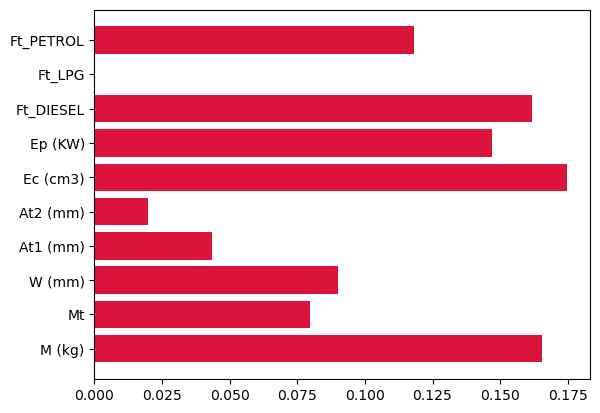

In [35]:
_, ax = plt.subplots()
bar_rects = ax.barh(np.arange(10), rfr_xf.feature_importances_, color='crimson', align='center')
ax.yaxis.set_ticks(np.arange(10), labels=XFEATURES);

#### Autre panel de 10 variables

In [38]:
XFEATURES=['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Z (Wh/km)', 
           'Fm_P', 'Ft_PETROL/ELECTRIC']

In [39]:
data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[XFEATURES], target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

base_rfr_xf = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=RANDOM_STATE)

In [40]:
%%time
train_scores_base_rfr_xf = cross_validate(base_rfr_xf, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                          cv=5, n_jobs=-1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_base_rfr_xf['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_base_rfr_xf['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_base_rfr_xf['fit_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.993717397731358
MAE: 2.275183428302455
Fit Time: 94
Wall time: 1min 43s


In [41]:
base_rfr_xf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=1492)

In [42]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {base_rfr_xf.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, base_rfr_xf.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9938225900276082
MAE: 2.263077153810929
Wall time: 1.39 s


In [43]:
tuned_rfr_xf = RandomForestRegressor(n_estimators=25, min_samples_split=4, max_features=5,
                                     n_jobs=-1, random_state=RANDOM_STATE)

In [44]:
train_scores_tuned_rfr_xf = cross_validate(tuned_rfr_xf, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                           cv=5, n_jobs=-1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_tuned_rfr_xf['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_tuned_rfr_xf['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_tuned_rfr_xf['fit_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.9940133767586925
MAE: 2.2486663628101304
Fit Time: 80


In [45]:
tuned_rfr_xf.fit(X_train, y_train)

RandomForestRegressor(max_features=5, min_samples_split=4, n_estimators=25,
                      n_jobs=-1, random_state=1492)

In [46]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {tuned_rfr_xf.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, tuned_rfr_xf.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9940585110877493
MAE: 2.2404283631233226
Wall time: 1.71 s


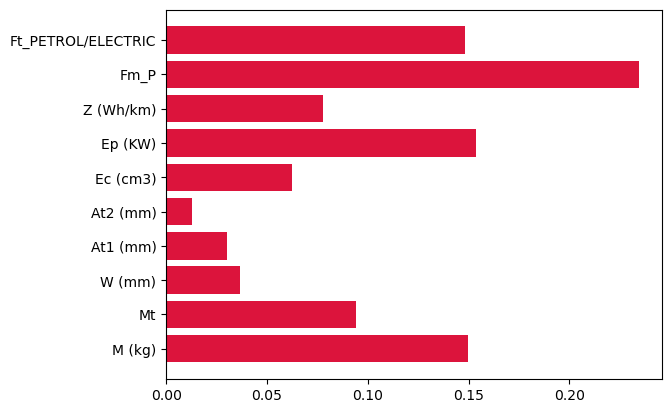

In [47]:
_, ax = plt.subplots()
bar_rects = ax.barh(np.arange(10), tuned_rfr_xf.feature_importances_, color='crimson', align='center')
ax.yaxis.set_ticks(np.arange(10), labels=XFEATURES);

#### 5 variables

In [14]:
FEATURE5 = ['M (kg)', 'Mt', 'W (mm)', 'Ec (cm3)', 'Ep (KW)']

In [15]:
data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[FEATURE5], target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [16]:
rfr_5f = RandomForestRegressor(n_estimators=25, min_samples_split=4, max_features=5, 
                               n_jobs=-1, random_state=RANDOM_STATE)

In [17]:
%%time
train_scores_rfr_5f = cross_validate(rfr_5f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'],
                                     cv=5, n_jobs=5)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_rfr_5f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_rfr_5f['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_rfr_5f['fit_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.9930908502447842
MAE: 2.4438125327280735
Fit Time: 96
Wall time: 1min 41s


In [18]:
rfr_5f.fit(X_train, y_train)

RandomForestRegressor(max_features=5, min_samples_split=4, n_estimators=25,
                      n_jobs=-1, random_state=1492)

In [19]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {rfr_5f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, rfr_5f.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9932276692957697
MAE: 2.4286550704461365
Wall time: 1.55 s


In [21]:
tuned_rfr_5f = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)

In [22]:
%%time
train_scores_tuned_5f = cross_validate(tuned_rfr_5f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                       cv=5, n_jobs=5, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_tuned_5f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_tuned_5f['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_tuned_5f['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min


=========== TRAINING ===================
R-squared: 0.9929679658752368
MAE: 2.4598295259464154
Fit Time: 74
Wall time: 1min 16s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.3min finished


In [23]:
tuned_rfr_5f.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.5s finished


RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=1492, verbose=1)

In [24]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {tuned_rfr_5f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, tuned_rfr_5f.predict(X_test))}")

=========== TESTING ===================


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


R-squared: 0.9931018436238204
MAE: 2.4413822378412533
Wall time: 1.22 s


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.5s finished


#### 3 variables

In [57]:
F3ATUR3S = ['M (kg)', 'Mt', 'Ep (KW)']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[F3ATUR3S], target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [58]:
rfr_3f = RandomForestRegressor(n_estimators=25, min_samples_split=4, n_jobs=-1, random_state=RANDOM_STATE)

In [59]:
%%time
train_scores_rfr_3f = cross_validate(rfr_3f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'],
                                     cv=5, n_jobs=5)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_rfr_3f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_rfr_3f['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_rfr_3f['fit_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.9622844264999566
MAE: 4.244400662370414
Fit Time: 69
Wall time: 1min 11s


In [60]:
rfr_3f.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=4, n_estimators=25, n_jobs=-1,
                      random_state=1492)

In [61]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {rfr_3f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, rfr_3f.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9630090289527327
MAE: 4.2260534200890705
Wall time: 1.42 s


In [38]:
tuned_rfr_3f = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)

In [39]:
%%time
train_scores_tuned_3f = cross_validate(tuned_rfr_3f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                       cv=5, n_jobs=5, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_tuned_3f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_tuned_3f['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_tuned_3f['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   55.7s remaining:  1.4min


=========== TRAINING ===================
R-squared: 0.9619336318527731
MAE: 4.257892186618715
Fit Time: 54
Wall time: 56.5 s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   56.3s finished


In [40]:
tuned_rfr_3f.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.2s finished


RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=1492, verbose=1)

In [41]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {tuned_rfr_3f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, tuned_rfr_3f.predict(X_test))}")

=========== TESTING ===================


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


R-squared: 0.9627076844884471
MAE: 4.237144717547309
Wall time: 1.15 s


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.5s finished


### [END] XB - 05/04/2023

## 6.10 GBoost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr=GradientBoostingRegressor()

In [ ]:
#1er essaie avec ces paramètres
params = {
    "n_estimators": 50,
    "max_depth": 2,
    "min_samples_split": 5,
    "learning_rate": 0.1,
}

In [ ]:
start_time = time.time()
reg = GradientBoostingRegressor(**params)
reg.fit(X_train_sc, y_train)
reg.score(X_test_sc, y_test)
print("Temps de l'entraînement  : "+format(time.time() - start_time))

In [ ]:
y_pred=reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse =mean_squared_error(y_test, y_pred)**0.5
print(rmse)

In [ ]:
#très lent avec les paramètres à défaut
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
y_pred1=reg.predict(X_test)
rmse =mean_squared_error(y_test, y_pred1)**0.5
print(rmse)

In [ ]:
from sklearn.model_selection import GridSearchCV
import time
start_time = time.time()
params1={'learning_rate': np.arange(0.1,1,0.1)}
grid=GridSearchCV(gbr, params1)
grid.fit(X_train_sc, y_train)
grid.best_estimator_
print("Temps de l'entraînement  : "+format(time.time() - start_time))

In [ ]:
y_pred=gbr.predict(X_test)
gbr.score(X_test_sc, y_test)

In [ ]:
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(n_estimators = 10, random_state = 0)
scores = cross_val_score(rf, X_train_sc, y_train, cv=5)
scores

#### [BEGIN] XB - 05/04/2023

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

In [14]:
data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data, target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [16]:
tuned_gbr_af = GradientBoostingRegressor(max_features='sqrt', min_samples_leaf=2, learning_rate=.3,
                                         max_depth=10, n_estimators=500, loss='squared_error', 
                                         random_state=RANDOM_STATE, verbose=1)

In [17]:
train_scores_tuned_gbr_af = cross_validate(tuned_gbr_af, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                           cv=5, n_jobs=5)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_tuned_gbr_af['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_tuned_gbr_af['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_tuned_gbr_af['fit_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.9949287731308916
MAE: 2.1637116461243573
Fit Time: 1459


In [18]:
tuned_gbr_af.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1        1089.6790           13.15m
         2         585.2623           14.49m
         3         335.7093           14.48m
         4         214.5056           14.28m
         5         146.6272           14.07m
         6         102.5126           14.18m
         7          81.8253           14.18m
         8          69.8615           14.12m
         9          60.1297           14.13m
        10          51.0636           14.25m
        20          28.7140           13.89m
        30          22.3046           13.50m
        40          19.1509           13.23m
        50          17.3595           12.95m
        60          15.9938           12.69m
        70          14.5976           12.36m
        80          13.6136           12.08m
        90          12.9398           11.82m
       100          12.5071           11.55m
       200          10.0831            8.69m
       300           9.1822            5.75m
       40

GradientBoostingRegressor(learning_rate=0.3, max_depth=10, max_features='sqrt',
                          min_samples_leaf=2, n_estimators=500,
                          random_state=1492, verbose=1)

In [19]:
%%time
print("=========== TESTING ================")
print(f"R-squared: {tuned_gbr_af.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, tuned_gbr_af.predict(X_test))}")

=========== TESTING ================
R-squared: 0.9948921766517232
MAE: 2.1579349939388908
Wall time: 13.2 s


#### Réduction de dimension - 10 variables

In [20]:
XFEATURES=['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Z (Wh/km)', 
           'Fm_P', 'Ft_PETROL/ELECTRIC']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[XFEATURES], target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [21]:
tuned_gbr = GradientBoostingRegressor(max_features='sqrt', min_samples_leaf=2, learning_rate=.3, 
                                      max_depth=10, n_estimators=300, loss='squared_error', random_state=RANDOM_STATE, 
                                      verbose=1)

In [22]:
%%time
train_scores_tuned_gbr = cross_validate(tuned_gbr, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'],
                                        cv=5, n_jobs=5, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_tuned_gbr['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_tuned_gbr['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_tuned_gbr['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 13.6min remaining: 20.5min


=========== TRAINING ===================
R-squared: 0.9948260094446887
MAE: 2.1753893676435987
Fit Time: 813
Wall time: 13min 40s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 13.7min finished


In [23]:
tuned_gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         994.0698            7.96m
         2         543.9667            8.14m
         3         310.4297            8.46m
         4         190.3695            8.59m
         5         126.9861            8.49m
         6          90.5048            8.42m
         7          70.0453            8.32m
         8          57.3309            8.23m
         9          49.3497            8.24m
        10          45.2614            8.14m
        20          24.6288            8.03m
        30          19.3357            7.85m
        40          16.2356            7.60m
        50          14.1914            7.26m
        60          13.1213            6.98m
        70          12.2942            6.68m
        80          11.6526            6.42m
        90          11.0275            6.16m
       100          10.6053            5.89m
       200           8.9424            2.93m
       300           8.3949            0.00s


GradientBoostingRegressor(learning_rate=0.3, max_depth=10, max_features='sqrt',
                          min_samples_leaf=2, n_estimators=300,
                          random_state=1492, verbose=1)

In [24]:
%%time
print("=========== TESTING ================")
print(f"R-squared: {tuned_gbr.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, tuned_gbr.predict(X_test))}")

=========== TESTING ================
R-squared: 0.9948139457051447
MAE: 2.1762486018148315
Wall time: 6.37 s


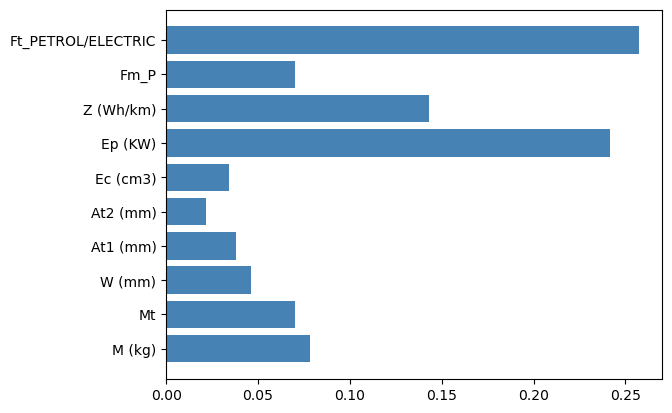

In [26]:
_, ax = plt.subplots()
bar_rects = ax.barh(np.arange(len(XFEATURES)), tuned_gbr.feature_importances_, color='steelblue', align='center')
ax.yaxis.set_ticks(np.arange(len(XFEATURES)), labels=XFEATURES);

#### 5 variables

In [27]:
FEATURE5 = ['Fm_P', 'Ft_PETROL/ELECTRIC', 'Mt', 'Ep (KW)', 'M (kg)']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[FEATURE5], target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [28]:
%%time
tuned_gbr_5f = GradientBoostingRegressor(max_features='sqrt', min_samples_leaf=2, learning_rate=.3,
                                         max_depth=10, n_estimators=300, loss='squared_error', 
                                         random_state=RANDOM_STATE, verbose=1)

train_scores_tuned_gbr_5f = cross_validate(tuned_gbr_5f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                           cv=5, n_jobs=5, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_tuned_gbr_5f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_tuned_gbr_5f['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_tuned_gbr_5f['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 10.7min remaining: 16.1min


=========== TRAINING ===================
R-squared: 0.9793560552560955
MAE: 3.8971867334467496
Fit Time: 639
Wall time: 10min 47s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 10.8min finished


In [29]:
tuned_gbr_5f.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1        1030.9229            6.68m
         2         581.2131            6.78m
         3         353.4293            7.03m
         4         241.2941            6.99m
         5         180.3313            6.90m
         6         149.7356            6.97m
         7         131.8715            6.89m
         8         118.2623            6.99m
         9         109.9709            6.89m
        10         105.4319            6.87m
        20          83.2191            6.71m
        30          69.0749            6.55m
        40          59.1946            6.35m
        50          55.1288            6.16m
        60          51.8234            5.92m
        70          49.1785            5.70m
        80          46.9522            5.48m
        90          45.0844            5.23m
       100          43.2106            4.97m
       200          37.4674            2.48m
       300          35.7748            0.00s


GradientBoostingRegressor(learning_rate=0.3, max_depth=10, max_features='sqrt',
                          min_samples_leaf=2, n_estimators=300,
                          random_state=1492, verbose=1)

In [30]:
%%time
print("=========== TESTING ================")
print(f"R-squared: {tuned_gbr_5f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, tuned_gbr_5f.predict(X_test))}")

=========== TESTING ================
R-squared: 0.9792712197765104
MAE: 3.8833429140131974
Wall time: 5.65 s


In [31]:
FEATURE5 = ['M (kg)', 'Mt', 'W (mm)', 'Ec (cm3)', 'Ep (KW)']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[FEATURE5], target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [32]:
%%time
tuned_gbr_5f = GradientBoostingRegressor(max_features='sqrt', min_samples_leaf=2, learning_rate=.3,
                                         max_depth=10, n_estimators=300, loss='squared_error', 
                                         random_state=RANDOM_STATE, verbose=1)

train_scores_tuned_gbr_5f = cross_validate(tuned_gbr_5f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                           cv=5, n_jobs=5, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_tuned_gbr_5f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_tuned_gbr_5f['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_tuned_gbr_5f['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 12.5min remaining: 18.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 12.6min finished


=========== TRAINING ===================
R-squared: 0.9938801684682966
MAE: 2.3651416946472716
Fit Time: 747
Wall time: 12min 37s


In [33]:
tuned_gbr_5f.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1        1059.2195            8.56m
         2         609.2476            8.27m
         3         357.9424            7.91m
         4         225.9517            7.80m
         5         151.2700            7.75m
         6         108.3556            7.73m
         7          83.4954            7.71m
         8          69.2727            7.76m
         9          58.6178            7.73m
        10          53.3318            7.69m
        20          23.6768            7.46m
        30          18.3397            7.25m
        40          15.7157            6.98m
        50          13.9854            6.74m
        60          13.1788            6.59m
        70          12.5497            6.30m
        80          12.0377            6.04m
        90          11.7330            5.78m
       100          11.4705            5.55m
       200          10.3030            2.79m
       300           9.8665            0.00s


GradientBoostingRegressor(learning_rate=0.3, max_depth=10, max_features='sqrt',
                          min_samples_leaf=2, n_estimators=300,
                          random_state=1492, verbose=1)

In [34]:
%%time
print("=========== TESTING ================")
print(f"R-squared: {tuned_gbr_5f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, tuned_gbr_5f.predict(X_test))}")

=========== TESTING ================
R-squared: 0.993997809487146
MAE: 2.352227513932955
Wall time: 6 s


In [37]:
F3ATUR3S = ['M (kg)', 'Mt', 'Ec (cm3)']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[F3ATUR3S], target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [38]:
%%time
tuned_gbr_3f = GradientBoostingRegressor(max_features='sqrt', min_samples_leaf=2, learning_rate=.3,
                                         max_depth=10, n_estimators=300, loss='squared_error', 
                                         random_state=RANDOM_STATE, verbose=1)

train_scores_tuned_gbr_3f = cross_validate(tuned_gbr_3f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                           cv=5, n_jobs=5, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_tuned_gbr_3f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_tuned_gbr_3f['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_tuned_gbr_3f['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  9.6min remaining: 14.4min


=========== TRAINING ===================
R-squared: 0.9773829134883881
MAE: 3.9906516082765244
Fit Time: 575
Wall time: 9min 40s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  9.7min finished


In [40]:
tuned_gbr_3f.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1        1184.8846            6.46m
         2         792.5354            6.46m
         3         573.6743            6.29m
         4         443.6076            6.30m
         5         355.1611            6.20m
         6         275.9179            6.03m
         7         225.4018            5.97m
         8         196.8537            5.91m
         9         187.8292            5.94m
        10         160.1983            5.93m
        20         101.8083            5.94m
        30          82.5243            5.82m
        40          68.5089            5.59m
        50          61.7415            5.39m
        60          56.2314            5.17m
        70          53.1784            5.05m
        80          50.3158            4.84m
        90          47.7923            4.62m
       100          46.6175            4.42m
       200          39.0328            2.24m
       300          36.8948            0.00s


GradientBoostingRegressor(learning_rate=0.3, max_depth=10, max_features='sqrt',
                          min_samples_leaf=2, n_estimators=300,
                          random_state=1492, verbose=1)

In [41]:
%%time
print("=========== TESTING ================")
print(f"R-squared: {tuned_gbr_3f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, tuned_gbr_3f.predict(X_test))}")

=========== TESTING ================
R-squared: 0.9775218380753081
MAE: 3.9741659670252556
Wall time: 6.46 s


#### [END] XB - 05/04/2023

## 6.11 Cat Boost Regressor

In [ ]:
pip install catboost

In [60]:
from catboost import Pool, CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm

In [ ]:
#params = {'iterations': 10000, 'learning_rate': 0.05, 'allow_writing_files': False, 'eval_metric': 'R2'}
#model = CatBoostRegressor(**params, random_seed=RANDOM_STATE)

In [62]:
start_time = time.time()
model = CatBoostRegressor()
model.fit(X_train_sc, y_train)
                           
print(model.score(X_test_sc, y_test))
print("Temps de l'entraînement  : "+format(time.time() - start_time))

Learning rate set to 0.123967
0:	learn: 39.2966643	total: 273ms	remaining: 4m 32s
1:	learn: 35.4080707	total: 356ms	remaining: 2m 57s
2:	learn: 32.1413888	total: 432ms	remaining: 2m 23s
3:	learn: 29.3798531	total: 520ms	remaining: 2m 9s
4:	learn: 26.9123701	total: 601ms	remaining: 1m 59s
5:	learn: 24.6617677	total: 681ms	remaining: 1m 52s
6:	learn: 23.4810262	total: 772ms	remaining: 1m 49s
7:	learn: 21.7444299	total: 859ms	remaining: 1m 46s
8:	learn: 20.3450709	total: 941ms	remaining: 1m 43s
9:	learn: 19.0844424	total: 1.03s	remaining: 1m 42s
10:	learn: 18.0136183	total: 1.11s	remaining: 1m 39s
11:	learn: 17.1728284	total: 1.19s	remaining: 1m 38s
12:	learn: 16.4164301	total: 1.29s	remaining: 1m 37s
13:	learn: 15.8236131	total: 1.37s	remaining: 1m 36s
14:	learn: 15.4927108	total: 1.45s	remaining: 1m 35s
15:	learn: 14.9800663	total: 1.55s	remaining: 1m 35s
16:	learn: 14.5071335	total: 1.63s	remaining: 1m 34s
17:	learn: 14.2114848	total: 1.71s	remaining: 1m 33s
18:	learn: 13.8809402	total

156:	learn: 7.2175923	total: 12.7s	remaining: 1m 8s
157:	learn: 7.2125586	total: 12.7s	remaining: 1m 7s
158:	learn: 7.1971825	total: 12.8s	remaining: 1m 7s
159:	learn: 7.1839980	total: 12.9s	remaining: 1m 7s
160:	learn: 7.1679188	total: 13s	remaining: 1m 7s
161:	learn: 7.1267890	total: 13.1s	remaining: 1m 7s
162:	learn: 7.1097073	total: 13.2s	remaining: 1m 7s
163:	learn: 7.1009807	total: 13.2s	remaining: 1m 7s
164:	learn: 7.0913107	total: 13.3s	remaining: 1m 7s
165:	learn: 7.0828036	total: 13.4s	remaining: 1m 7s
166:	learn: 7.0665551	total: 13.4s	remaining: 1m 7s
167:	learn: 7.0561157	total: 13.5s	remaining: 1m 6s
168:	learn: 7.0368422	total: 13.6s	remaining: 1m 6s
169:	learn: 7.0290228	total: 13.7s	remaining: 1m 6s
170:	learn: 7.0139338	total: 13.8s	remaining: 1m 6s
171:	learn: 7.0002129	total: 13.9s	remaining: 1m 6s
172:	learn: 6.9883834	total: 13.9s	remaining: 1m 6s
173:	learn: 6.9765551	total: 14s	remaining: 1m 6s
174:	learn: 6.9666457	total: 14.1s	remaining: 1m 6s
175:	learn: 6.95

316:	learn: 5.9864794	total: 25s	remaining: 53.8s
317:	learn: 5.9844087	total: 25.1s	remaining: 53.7s
318:	learn: 5.9753037	total: 25.1s	remaining: 53.6s
319:	learn: 5.9695304	total: 25.2s	remaining: 53.6s
320:	learn: 5.9670748	total: 25.3s	remaining: 53.5s
321:	learn: 5.9637647	total: 25.4s	remaining: 53.4s
322:	learn: 5.9550940	total: 25.4s	remaining: 53.3s
323:	learn: 5.9516059	total: 25.5s	remaining: 53.2s
324:	learn: 5.9471239	total: 25.6s	remaining: 53.1s
325:	learn: 5.9409571	total: 25.7s	remaining: 53.1s
326:	learn: 5.9399097	total: 25.7s	remaining: 53s
327:	learn: 5.9357478	total: 25.8s	remaining: 52.9s
328:	learn: 5.9301072	total: 25.9s	remaining: 52.8s
329:	learn: 5.9263796	total: 26s	remaining: 52.7s
330:	learn: 5.9223799	total: 26s	remaining: 52.6s
331:	learn: 5.9206466	total: 26.1s	remaining: 52.5s
332:	learn: 5.9131611	total: 26.2s	remaining: 52.5s
333:	learn: 5.9092081	total: 26.3s	remaining: 52.4s
334:	learn: 5.9063761	total: 26.3s	remaining: 52.3s
335:	learn: 5.902735

475:	learn: 5.3187942	total: 37.9s	remaining: 41.7s
476:	learn: 5.3045925	total: 38s	remaining: 41.6s
477:	learn: 5.3009514	total: 38s	remaining: 41.5s
478:	learn: 5.2965131	total: 38.1s	remaining: 41.5s
479:	learn: 5.2951783	total: 38.2s	remaining: 41.4s
480:	learn: 5.2906873	total: 38.3s	remaining: 41.3s
481:	learn: 5.2859292	total: 38.4s	remaining: 41.2s
482:	learn: 5.2839331	total: 38.5s	remaining: 41.2s
483:	learn: 5.2804743	total: 38.5s	remaining: 41.1s
484:	learn: 5.2770855	total: 38.6s	remaining: 41s
485:	learn: 5.2746154	total: 38.7s	remaining: 41s
486:	learn: 5.2724215	total: 38.8s	remaining: 40.9s
487:	learn: 5.2651990	total: 39s	remaining: 40.9s
488:	learn: 5.2620532	total: 39.1s	remaining: 40.8s
489:	learn: 5.2592635	total: 39.2s	remaining: 40.8s
490:	learn: 5.2575826	total: 39.3s	remaining: 40.7s
491:	learn: 5.2436535	total: 39.4s	remaining: 40.7s
492:	learn: 5.2408205	total: 39.5s	remaining: 40.6s
493:	learn: 5.2371863	total: 39.6s	remaining: 40.6s
494:	learn: 5.2341841	

635:	learn: 4.9012492	total: 51.5s	remaining: 29.5s
636:	learn: 4.8998208	total: 51.6s	remaining: 29.4s
637:	learn: 4.8990792	total: 51.7s	remaining: 29.3s
638:	learn: 4.8967260	total: 51.8s	remaining: 29.3s
639:	learn: 4.8957623	total: 51.9s	remaining: 29.2s
640:	learn: 4.8940375	total: 51.9s	remaining: 29.1s
641:	learn: 4.8924555	total: 52s	remaining: 29s
642:	learn: 4.8913159	total: 52.1s	remaining: 28.9s
643:	learn: 4.8904051	total: 52.2s	remaining: 28.9s
644:	learn: 4.8870619	total: 52.3s	remaining: 28.8s
645:	learn: 4.8857494	total: 52.3s	remaining: 28.7s
646:	learn: 4.8835537	total: 52.4s	remaining: 28.6s
647:	learn: 4.8825740	total: 52.5s	remaining: 28.5s
648:	learn: 4.8774343	total: 52.6s	remaining: 28.4s
649:	learn: 4.8764917	total: 52.7s	remaining: 28.4s
650:	learn: 4.8740177	total: 52.8s	remaining: 28.3s
651:	learn: 4.8720578	total: 52.9s	remaining: 28.2s
652:	learn: 4.8696404	total: 53s	remaining: 28.2s
653:	learn: 4.8681572	total: 53.1s	remaining: 28.1s
654:	learn: 4.8658

795:	learn: 4.6358398	total: 1m 4s	remaining: 16.5s
796:	learn: 4.6340462	total: 1m 4s	remaining: 16.4s
797:	learn: 4.6334358	total: 1m 4s	remaining: 16.3s
798:	learn: 4.6321832	total: 1m 4s	remaining: 16.2s
799:	learn: 4.6308343	total: 1m 4s	remaining: 16.1s
800:	learn: 4.6296445	total: 1m 4s	remaining: 16.1s
801:	learn: 4.6273885	total: 1m 4s	remaining: 16s
802:	learn: 4.6266710	total: 1m 4s	remaining: 15.9s
803:	learn: 4.6255695	total: 1m 4s	remaining: 15.8s
804:	learn: 4.6246389	total: 1m 4s	remaining: 15.7s
805:	learn: 4.6219787	total: 1m 5s	remaining: 15.7s
806:	learn: 4.6202132	total: 1m 5s	remaining: 15.6s
807:	learn: 4.6188436	total: 1m 5s	remaining: 15.5s
808:	learn: 4.6177475	total: 1m 5s	remaining: 15.4s
809:	learn: 4.6167454	total: 1m 5s	remaining: 15.3s
810:	learn: 4.6156895	total: 1m 5s	remaining: 15.2s
811:	learn: 4.6143147	total: 1m 5s	remaining: 15.2s
812:	learn: 4.6124544	total: 1m 5s	remaining: 15.1s
813:	learn: 4.6118891	total: 1m 5s	remaining: 15s
814:	learn: 4.60

953:	learn: 4.4348248	total: 1m 17s	remaining: 3.74s
954:	learn: 4.4333324	total: 1m 17s	remaining: 3.66s
955:	learn: 4.4325621	total: 1m 17s	remaining: 3.58s
956:	learn: 4.4307855	total: 1m 17s	remaining: 3.5s
957:	learn: 4.4297780	total: 1m 17s	remaining: 3.41s
958:	learn: 4.4286935	total: 1m 17s	remaining: 3.33s
959:	learn: 4.4274762	total: 1m 18s	remaining: 3.25s
960:	learn: 4.4267130	total: 1m 18s	remaining: 3.17s
961:	learn: 4.4253703	total: 1m 18s	remaining: 3.09s
962:	learn: 4.4242000	total: 1m 18s	remaining: 3.01s
963:	learn: 4.4222497	total: 1m 18s	remaining: 2.93s
964:	learn: 4.4208489	total: 1m 18s	remaining: 2.85s
965:	learn: 4.4198909	total: 1m 18s	remaining: 2.77s
966:	learn: 4.4190586	total: 1m 18s	remaining: 2.69s
967:	learn: 4.4177757	total: 1m 18s	remaining: 2.6s
968:	learn: 4.4171712	total: 1m 18s	remaining: 2.52s
969:	learn: 4.4161527	total: 1m 18s	remaining: 2.44s
970:	learn: 4.4154209	total: 1m 19s	remaining: 2.36s
971:	learn: 4.4137884	total: 1m 19s	remaining: 2

## 6.12 XGradientBoosting Resgressor (XGBR)

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_validate
import numpy as np
import time


In [16]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [20]:
#test avec 10 variables pour les features avec CV 
start_time = time.time()
rg = XGBRegressor()
scores = cross_val_score(rg, X_train_sc, y_train, cv=5)
    
print(scores.mean())
print("Temps de l'entraînement  : "+format(time.time() - start_time))

0.9888146213455726
Temps de l'entraînement  : 173.37888550758362


In [14]:
start_time = time.time()
rg = XGBRegressor()
rg.fit(X_train_sc, y_train)
                           
print(rg.score(X_test_sc, y_test))
print("Temps de l'entraînement  : "+format(time.time() - start_time))

0.9897620626556655
Temps de l'entraînement  : 126.76611065864563


## 6.13 Extra tree regressor

In [21]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.model_selection import cross_val_score
import numpy as np
import time


In [23]:
start_time = time.time()

#nombre d'estimateurs : 100
rf = ExtraTreesRegressor()
scores = cross_val_score(rf, X_train_sc, y_train, cv=5)
print(scores.mean())
print("Temps de l'entraînement  : "+format(time.time() - start_time))
#class sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)

0.9930444493607855
Temps de l'entraînement  : 1026.9287207126617


In [44]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [46]:
# use Kernel SHAP to explain test set predictions
import shap
rf = ExtraTreesRegressor()
rf.fit(X_train_sc, y_train)
explainer = shap.KernelExplainer(rf.predict, X_train_sc, link="logit")
shap_values = explainer.shap_values(X_train_sc)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0, :], X_test_sc.iloc[0, :], link="logit")

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
Using 1109429 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
invalid value encountered in log
invalid value encountered in f (vectorized)


  0%|          | 0/1109429 [00:00<?, ?it/s]

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names


MemoryError: Unable to allocate 42.2 GiB for an array with shape (1022, 11094290) and data type float32

Pour ce cas en utilisant le modèle Extra Tree Regressor, Shap n'est pas concluant.

In [16]:
#2ème test
start_time = time.time()
from sklearn.model_selection import cross_val_score

scores_list =[]
n_estimators_list = [1,4,7,10]

for i in n_estimators_list:
    
    rf = ExtraTreesRegressor(n_estimators = i)
    scores = cross_val_score(rf, X_train_sc, y_train, cv=5)
    
    scores_list.append(scores.mean())
    print(scores.mean())
    print("Temps de l'entraînement  : "+format(time.time() - start_time))

0.9923855223884394
Temps de l'entraînement  : 23.975226879119873
0.9930437298286372
Temps de l'entraînement  : 109.68246054649353
0.993150595733535
Temps de l'entraînement  : 264.3824932575226
0.9931810244515175
Temps de l'entraînement  : 484.2604470252991


In [12]:
from sklearn.model_selection import GridSearchCV
start_time = time.time()
rg = ExtraTreesRegressor()

parametres = {
    'n_estimators': [1,10],
    #'max_depth': [5,30,100],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,5,10],
    #'oob_score': [True, False],   
    #'bootstrap': [True, False],
}

grid_rg = GridSearchCV(estimator=rg,param_grid = parametres,cv=5)
grille = grid_rg.fit(X_train_sc, y_train)
print(pd.DataFrame.from_dict(grille.cv_results_))
print(f'Best Parameters: {grid_rg.best_params_}')
print("Temps de l'entraînement  : "+format(time.time() - start_time))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        8.811421      0.073420         0.185695        0.002438   
1       82.219140      1.377054         1.359293        0.016459   
2        8.559664      0.175078         0.172806        0.002360   
3       79.996352      0.886871         1.351803        0.130653   
4        8.335009      0.467599         0.163686        0.002276   
5       80.139245      0.813304         1.175928        0.010005   
6        8.235240      0.258780         0.142545        0.002506   
7       78.299465      1.064679         0.945969        0.012301   
8        8.362845      0.071271         0.142455        0.004104   
9       76.372280      0.485745         0.937532        0.006087   
10       8.182144      0.134431         0.141445        0.002960   
11      76.779300      0.701834         0.934356        0.009327   
12       8.042417      0.335404         0.119839        0.002860   
13      75.902303      0.960899         0.761167

In [24]:
#si on redémarre :
start_time = time.time()
rg = ExtraTreesRegressor(n_estimators=10,min_samples_leaf=1,min_samples_split=10)

scores_train = cross_val_score(rg, X_train_sc, y_train, cv=5)
scores_test = cross_val_score(rg, X_test_sc, y_test, cv=5)

print('score train : ',scores_train.mean())
print('score test : ',scores_test.mean())

print("Temps de l'entraînement  : "+format(time.time() - start_time))

score train :  0.9946420798637267
score test :  0.9940659412126612
Temps de l'entraînement  : 492.71798372268677


## 6.14 K-NN regressor

In [13]:

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor
import time


In [17]:
#1er test avec toutes les variables

start_time = time.time()
knnr = KNeighborsRegressor(n_neighbors=3)
knnr.fit(X_train_sc, y_train)
                      
print(knnr.score(X_test_sc, y_test))
print("Temps de l'entraînement  : "+format(time.time() - start_time))

0.9934093371187905
Temps de l'entraînement  : 6757.46862578392


In [14]:
features = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Ft_DIESEL', 'Ft_LPG', 'Ft_PETROL']
X_train_sc = X_train_sc[features]
X_test_sc = X_test_sc[features]

In [19]:
#test avec 10 variables pour les features

start_time = time.time()
knnr = KNeighborsRegressor(n_neighbors=3)
knnr.fit(X_train_sc, y_train)
                           
print(knnr.score(X_test_sc, y_test))
print("Temps de l'entraînement  : "+format(time.time() - start_time))

0.9927699275438332
Temps de l'entraînement  : 24.60731053352356


In [23]:
#test avec 10 variables pour les features avec CV 
start_time = time.time()
knnr = KNeighborsRegressor(n_neighbors=3)
scores = cross_val_score(knnr, X_train_sc, y_train, cv=3)
    
print(scores.mean())
print("Temps de l'entraînement  : "+format(time.time() - start_time))

0.9924209057062328
Temps de l'entraînement  : 75.06693053245544


In [14]:
#tuning avec CV
start_time = time.time()

scores_list =[]
n_estimators_list = [1,2,3,4,5,6,7,8,9,10]

for i in n_estimators_list:

    knnr = KNeighborsRegressor(n_neighbors=i)
    scores = cross_val_score(knnr, X_train_sc, y_train, cv=5)
    
    print(scores.mean())
    print("Temps de l'entraînement  : "+format(time.time() - start_time))
    #
    scores = cross_val_score(knnr, X_test_sc, y_test, cv=5)
    
    print(scores.mean())
    print("Temps de l'entraînement  : "+format(time.time() - start_time))

0.9895083273853233
Temps de l'entraînement  : 95.40834045410156
0.9918872836563896
Temps de l'entraînement  : 192.01350903511047
0.9925491045840236
Temps de l'entraînement  : 287.28948402404785
0.9928299650854415
Temps de l'entraînement  : 384.01377868652344
0.9929626875655695
Temps de l'entraînement  : 482.3963625431061
0.9930300090437931
Temps de l'entraînement  : 581.9411420822144
0.9930564973774538
Temps de l'entraînement  : 683.2087383270264
0.9930462058694071
Temps de l'entraînement  : 785.7469463348389
0.9930188278806427
Temps de l'entraînement  : 891.8792812824249
0.992977745626076
Temps de l'entraînement  : 1002.6848754882812


In [30]:
#tuning avec CV avec la métrique manhattan
start_time = time.time()

scores_list =[]
n_estimators_list = [1,2,3,4,5,6,7,8,9,10]

for i in n_estimators_list:

    knnr = KNeighborsRegressor(n_neighbors=i,metric = 'manhattan')
    scores = cross_val_score(knnr, X_train_sc, y_train, cv=3)
    
    print(scores.mean())
    print("Temps de l'entraînement  : "+format(time.time() - start_time))

0.9896502549518251
Temps de l'entraînement  : 66.66332817077637
0.9920482254533791
Temps de l'entraînement  : 134.99333906173706
0.9927978805913239
Temps de l'entraînement  : 205.18388056755066
0.9931438726795294
Temps de l'entraînement  : 277.6473422050476
0.9933061407232596
Temps de l'entraînement  : 351.8599154949188
0.9933860692800126
Temps de l'entraînement  : 427.7836992740631
0.99342179331522
Temps de l'entraînement  : 504.83802700042725
0.9934332724127222
Temps de l'entraînement  : 582.3058557510376
0.9934234398247236
Temps de l'entraînement  : 661.250274181366
0.9934008590639235
Temps de l'entraînement  : 741.4654486179352


In [15]:
from sklearn.model_selection import GridSearchCV
start_time = time.time()
rg = KNeighborsRegressor()
parametres = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10], 'metric':['euclidean','manhattan']}
grid_rg = GridSearchCV(estimator=rg,param_grid = parametres,cv=5)

grille = grid_rg.fit(X_train_sc, y_train)
print(pd.DataFrame.from_dict(grille.cv_results_))
print(f'Best Parameters: {grid_rg.best_params_}')
print("Temps de l'entraînement  : "+format(time.time() - start_time))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_metric  \
0        5.424764      0.071858        12.652668        0.245676    euclidean   
1        5.495678      0.163103        13.067109        0.250873    euclidean   
2        5.451337      0.100786        13.424433        0.272529    euclidean   
3        5.398957      0.046748        13.769062        0.281943    euclidean   
4        5.419095      0.037655        14.125773        0.289331    euclidean   
5        5.423565      0.040418        14.485123        0.353324    euclidean   
6        5.456853      0.039353        14.890224        0.203317    euclidean   
7        5.423870      0.029733        15.014894        0.287968    euclidean   
8        5.390730      0.035194        15.329663        0.292952    euclidean   
9        5.533870      0.073653        15.762870        0.344275    euclidean   
10       5.500339      0.051487        12.020756        0.251482    manhattan   
11       5.483966      0.032

In [16]:
print('score test : ',grid_rg.score(X_test_sc,y_test))

score test :  0.9937197747442753


In [ ]:
# use Kernel SHAP to explain test set predictions
import shap
#rf = ExtraTreesRegressor()
#rf.fit(X_train_sc, y_train)
explainer = shap.KernelExplainer(grid_rg.predict, X_train_sc, link="logit")
shap_values = explainer.shap_values(X_train_sc)

# plot the SHAP values for the Setosa output of the first instance
#shap.force_plot(explainer.expected_value[0], shap_values[0][0, :], X_test_sc.iloc[0, :], link="logit")

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
Using 1109429 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
invalid value encountered in log
invalid value encountered in f (vectorized)


  0%|          | 0/1109429 [00:00<?, ?it/s]

Pour ce cas également, Shap est beaucoup trop lent à l'exécution.

## 6.15 LightGBM

In [34]:
pip install lightgbm

In [14]:
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error 
from lightgbm import LGBMRegressor
import time

In [46]:
features = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Ft_DIESEL', 'Ft_LPG', 'Ft_PETROL']
X_train_sc = X_train_sc[features]
X_test_sc = X_test_sc[features]

In [26]:
#test avec 10 variables pour les features
start_time = time.time()
rg = LGBMRegressor()
scores = cross_val_score(rg, X_train_sc, y_train, cv=5)
    
print(scores.mean())
print("Temps de l'entraînement  : "+format(time.time() - start_time))

0.9790667709812408
Temps de l'entraînement  : 16.425954341888428


In [27]:
#tuning avec CV
start_time = time.time()
#learning rate par défaut : 0.1
max_depth_list = [10, 100,500]
trees = [10, 100, 500, 1000,5000,10000]

for j in trees:
    for i in max_depth_list:
    
        rg = LGBMRegressor(max_depth = i, num_leaves = j)
        scores = cross_val_score(rg, X_train_sc, y_train, cv=5)
        print('maxdepth ',i,' trees ',j)
        print(scores.mean())
        print("Temps de l'entraînement  : "+format(time.time() - start_time))

maxdepth  10  trees  10
0.9549039700625235
Temps de l'entraînement  : 10.76519250869751
maxdepth  100  trees  10
0.9549039700625235
Temps de l'entraînement  : 21.850802421569824
maxdepth  500  trees  10
0.9549039700625235
Temps de l'entraînement  : 32.70081090927124
maxdepth  10  trees  100
0.988170962728017
Temps de l'entraînement  : 53.48570966720581
maxdepth  100  trees  100
0.9886856630572923
Temps de l'entraînement  : 75.91584062576294
maxdepth  500  trees  100
0.9886858014742188
Temps de l'entraînement  : 98.6837477684021
maxdepth  10  trees  500
0.9920369891911868
Temps de l'entraînement  : 130.163902759552
maxdepth  100  trees  500
0.993610546668851
Temps de l'entraînement  : 165.27626967430115
maxdepth  500  trees  500
0.993610546668851
Temps de l'entraînement  : 200.77501940727234
maxdepth  10  trees  1000
0.9920288669313573
Temps de l'entraînement  : 229.47757267951965
maxdepth  100  trees  1000
0.994130924164281
Temps de l'entraînement  : 282.36113810539246
maxdepth  500  t

In [58]:
#tuning avec CV et en faisant varier le taux d'apprentissage
start_time = time.time()
#learning rate par défaut : 0.1
learning_rate_list = [0.01, 0.1, 0.5, 1.0]
trees = [1000,5000]

for i in learning_rate_list:
    for j in trees:
        rg = LGBMRegressor(max_depth = 100, learning_rate = i, num_leaves = j)
        scores = cross_val_score(rg, X_train_sc, y_train, cv=3)
        print('rates ',i,' trees ',j)
        print(scores.mean())
        print("Temps de l'entraînement  : "+format(time.time() - start_time))

rates  0.01  trees  1000
0.8562312095006748
Temps de l'entraînement  : 29.0671124458313
rates  0.01  trees  5000
0.8597096193660009
Temps de l'entraînement  : 115.10483407974243
rates  0.1  trees  1000
0.994049543034965
Temps de l'entraînement  : 142.52324199676514
rates  0.1  trees  5000
0.9942118423590016
Temps de l'entraînement  : 225.30372881889343
rates  0.5  trees  1000
0.9941716004232601
Temps de l'entraînement  : 247.7006278038025
rates  0.5  trees  5000
0.994047265440842
Temps de l'entraînement  : 331.4542682170868
rates  1.0  trees  1000
0.9936105261822731
Temps de l'entraînement  : 352.6662230491638
rates  1.0  trees  5000
0.9935878850930749
Temps de l'entraînement  : 439.2946810722351


In [31]:
from sklearn.model_selection import GridSearchCV
start_time = time.time()
rg = LGBMRegressor(max_depth = 100)
parametres = {'learning_rate':[0.01, 0.1, 0.5, 1.0], 'num_leaves':[2000,3000,4000,5000,6000,7000,8000]}
grid_rg = GridSearchCV(estimator=rg,param_grid = parametres,cv=5)

#grille = grid_rg.fit(X_train_sc, y_train)
print(pd.DataFrame.from_dict(grille.cv_results_))
print(f'Best Parameters: {grid_rg.best_params_}')
print("Temps de l'entraînement  : "+format(time.time() - start_time))




    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       14.402860      0.102221         1.200619        0.027512   
1       18.245971      0.063267         1.681243        0.011213   
2       23.340094      0.879408         2.159288        0.047425   
3       27.312263      1.093334         2.593687        0.100394   
4       30.751134      0.910356         2.879878        0.045949   
5       37.347046      4.007818         3.408119        0.636635   
6       41.209547      1.910876         3.435100        0.115818   
7       13.413042      0.785594         1.821314        0.135135   
8       15.810410      0.364415         2.363839        0.307937   
9       19.800039      0.725721         2.940886        0.222574   
10      23.700488      0.985163         3.440755        0.035924   
11      30.662845      2.857073         4.546241        0.618423   
12      32.469279      1.069262         4.595345        0.061531   
13      37.980638      1.511305         5.055733

In [12]:
y_pred_test = grid_rg.score(X_test_sc,y_test)

In [17]:
#si on redémarre :
start_time = time.time()
rg = LGBMRegressor(learning_rate=0.1, num_leaves=3000)
rg.fit(X_train_sc, y_train)
print('score train : ',rg.score(X_train_sc,y_train))
print('score test : ',rg.score(X_test_sc,y_test))
print("Temps de l'entraînement  : "+format(time.time() - start_time))

score train :  0.9954969362404997
score test :  0.994807330217778
Temps de l'entraînement  : 43.092020750045776


### [BEGIN] XB - 01/04/2023

In [8]:
from lightgbm import LGBMRegressor

In [10]:
data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data, target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [14]:
base_model = LGBMRegressor(force_row_wise=True, random_state=RANDOM_STATE, verbose=2)

In [15]:
%%time
train_scores_lgmb = cross_validate(base_model, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                   cv=5, n_jobs=-1, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_lgmb['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_lgmb['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_lgmb['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.1s remaining:   27.2s


=========== TRAINING ===================
R-squared: 0.9837902611406901
MAE: 4.173569322586746
Fit Time: 16
Wall time: 20.6 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


In [16]:
base_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.549484
[LightGBM] [Info] Total Bins 1737
[LightGBM] [Info] Number of data points in the train set: 1109429, number of used features: 79
[LightGBM] [Info] Start training from score 153.783990
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM

LGBMRegressor(force_row_wise=True, random_state=1492, verbose=2)

In [18]:
%%time
print("=========== TESTING ================")
print(f"R-squared: {base_model.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, base_model.predict(X_test))}")

=========== TESTING ================
R-squared: 0.9839340422670556
MAE: 4.140418401015276
Wall time: 1.09 s


In [25]:
tuned_lgbm:LGBMRegressor = LGBMRegressor(num_leaves=3000, learning_rate=.1, 
                                         force_row_wise=True, random_state=RANDOM_STATE, verbose=1)

In [26]:
%%time
train_scores_tuned_lgbm = cross_validate(tuned_lgbm, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                         cv=5, n_jobs=-1, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_tuned_lgbm['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_tuned_lgbm['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_tuned_lgbm['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.0min


=========== TRAINING ===================
R-squared: 0.9948333617930277
MAE: 2.130302916605137
Fit Time: 62
Wall time: 1min 21s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


In [27]:
tuned_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1737
[LightGBM] [Info] Number of data points in the train set: 1109429, number of used features: 79
[LightGBM] [Info] Start training from score 153.783990


LGBMRegressor(force_row_wise=True, num_leaves=3000, random_state=1492,
              verbose=1)

In [24]:
%%time
print("=========== TESTING ================")
print(f"R-squared: {tuned_lgbm.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, tuned_lgbm.predict(X_test))}")

=========== TESTING ================
R-squared: 0.994775997929868
MAE: 2.1759146134998533
Wall time: 9.78 s


#### Réduction de dimension

##### 10 variables

In [10]:
XFEATURES = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ec (cm3)', 'Ep (KW)', 'Z (Wh/km)', 
             'Fm_P', 'Ft_PETROL/ELECTRIC']
data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[XFEATURES], target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

lgbm_xf = LGBMRegressor(num_leaves=3000, learning_rate=.1, force_row_wise=True, random_state=RANDOM_STATE)

In [11]:
%%time
train_scores_lgbm_xf = cross_validate(lgbm_xf, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                      cv=5, n_jobs=-1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_lgbm_xf['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_lgbm_xf['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_lgbm_xf['fit_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.9946453828343117
MAE: 2.1606099087428303
Fit Time: 55
Wall time: 1min 22s


In [12]:
lgbm_xf.fit(X_train, y_train)

LGBMRegressor(force_row_wise=True, num_leaves=3000, random_state=1492)

In [13]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {lgbm_xf.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, lgbm_xf.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9946741832853176
MAE: 2.153126318422921
Wall time: 4.23 s


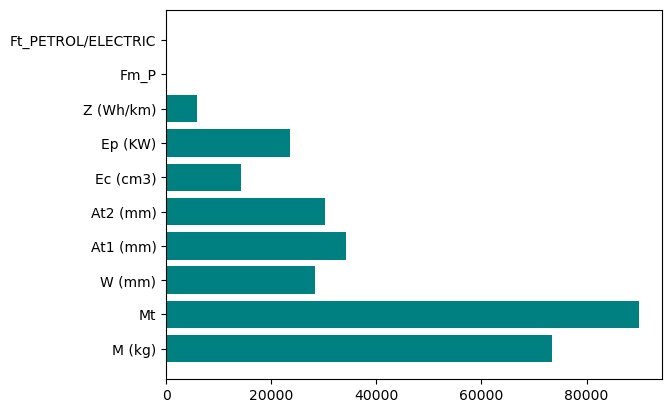

In [14]:
_, ax = plt.subplots()
bar_rects = ax.barh(np.arange(len(XFEATURES)), lgbm_xf.feature_importances_, color='teal', align='center')
ax.yaxis.set_ticks(np.arange(len(XFEATURES)), labels=XFEATURES);

##### 6 variables

In [16]:
F6ATUR6S = ['M (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'Ec (cm3)', 'Ep (KW)']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[F6ATUR6S], target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

lgbm_6f = LGBMRegressor(num_leaves=3000, learning_rate=.1, force_row_wise=True, random_state=RANDOM_STATE)

In [17]:
%%time
train_scores_lgbm_6f = cross_validate(lgbm_6f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                      cv=5, n_jobs=-1, verbose=1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_lgbm_6f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_lgbm_6f['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_lgbm_6f['fit_time'].mean()).round():.0f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min


=========== TRAINING ===================
R-squared: 0.9939436437140671
MAE: 2.2753523203928774
Fit Time: 44
Wall time: 1min 7s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [18]:
lgbm_6f.fit(X_train, y_train)

LGBMRegressor(force_row_wise=True, num_leaves=3000, random_state=1492)

In [19]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {lgbm_6f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, lgbm_6f.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9940798532858857
MAE: 2.2692538421916377
Wall time: 4.44 s


##### 5 variables

In [20]:
FEATURE5=['M (kg)', 'W (mm)', 'At1 (mm)', 'Ec (cm3)', 'Ep (KW)']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[FEATURE5], target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

lgbm_5f = LGBMRegressor(num_leaves=3000, learning_rate=.1, force_row_wise=True, random_state=RANDOM_STATE)

In [21]:
%%time
train_scores_lgbm_5f = cross_validate(lgbm_5f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                      cv=5, n_jobs=-1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_lgbm_5f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_lgbm_5f['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_lgbm_5f['fit_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.9923056666545556
MAE: 2.6918772273508873
Fit Time: 49
Wall time: 1min 16s


In [22]:
lgbm_5f.fit(X_train, y_train)

LGBMRegressor(force_row_wise=True, num_leaves=3000, random_state=1492)

In [23]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {lgbm_5f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, lgbm_5f.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9924127282626398
MAE: 2.6921079726406822
Wall time: 5.2 s


In [24]:
FEATURE5=['M (kg)', 'Mt', 'At1 (mm)', 'Ep (KW)', 'W (mm)']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[FEATURE5], target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

lgbm_5f = LGBMRegressor(num_leaves=3000, learning_rate=.1, force_row_wise=True, random_state=RANDOM_STATE)

In [25]:
%%time
train_scores_lgbm_5f = cross_validate(lgbm_5f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                      cv=5, n_jobs=-1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_lgbm_5f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_lgbm_5f['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_lgbm_5f['fit_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.9930078110105665
MAE: 2.355869218357756
Fit Time: 44
Wall time: 1min 7s


In [26]:
lgbm_5f.fit(X_train, y_train)

LGBMRegressor(force_row_wise=True, num_leaves=3000, random_state=1492)

In [27]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {lgbm_5f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, lgbm_5f.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9932319145734624
MAE: 2.3444066175307974
Wall time: 4.48 s


In [28]:
FEATURE5=['M (kg)', 'Mt', 'At1 (mm)', 'Ep (KW)', 'Ec (cm3)']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[FEATURE5], target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

lgbm_5f = LGBMRegressor(num_leaves=3000, learning_rate=.1, force_row_wise=True, random_state=RANDOM_STATE)

In [29]:
%%time
train_scores_lgbm_5f = cross_validate(lgbm_5f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                      cv=5, n_jobs=-1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_lgbm_5f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_lgbm_5f['test_neg_mean_absolute_error'].mean())}")
print(f"Total Time: {(train_scores_lgbm_5f['fit_time'].mean() + train_scores_lgbm_5f['score_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.9932618319739597
MAE: 2.3747688232143958
Total Time: 68
Wall time: 1min 8s


In [30]:
lgbm_5f.fit(X_train, y_train)

LGBMRegressor(force_row_wise=True, num_leaves=3000, random_state=1492)

In [31]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {lgbm_5f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, lgbm_5f.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9933612419544027
MAE: 2.3702501399401177
Wall time: 4.53 s


In [32]:
# MEILLEURE COMBINAISON pour 5 FEATURES
FEATURE5=['M (kg)', 'Mt', 'W (mm)', 'Ep (KW)', 'Ec (cm3)']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[FEATURE5], target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

lgbm_5f = LGBMRegressor(num_leaves=3000, learning_rate=.1, force_row_wise=True, random_state=RANDOM_STATE)

In [33]:
%%time
train_scores_lgbm_5f = cross_validate(lgbm_5f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                      cv=5, n_jobs=-1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_lgbm_5f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_lgbm_5f['test_neg_mean_absolute_error'].mean())}")
print(f"Total Time: {(train_scores_lgbm_5f['fit_time'].mean() + train_scores_lgbm_5f['score_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.9934603353607612
MAE: 2.3888996696783624
Total Time: 64
Wall time: 1min 6s


In [34]:
lgbm_5f.fit(X_train, y_train)

LGBMRegressor(force_row_wise=True, num_leaves=3000, random_state=1492)

In [35]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {lgbm_5f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, lgbm_5f.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9935539261684762
MAE: 2.3837074079715492
Wall time: 4.46 s


##### 3 variables

In [44]:
# MEILLEURE COMBINAISON pour 3 FEATURES
F3ATUR3S=['M (kg)', 'Mt', 'Ec (cm3)']

data = df.drop(columns=ENEDC_EWLTP_COLNAMES)
target = df[TARGET_NAME]

X, y = data[F3ATUR3S], target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

lgbm_3f = LGBMRegressor(num_leaves=3000, learning_rate=.1, force_row_wise=True, random_state=RANDOM_STATE)

In [45]:
%%time
train_scores_lgbm_3f = cross_validate(lgbm_3f, X_train, y_train, scoring=['r2', 'neg_mean_absolute_error'], 
                                      cv=5, n_jobs=-1)
print("=========== TRAINING ===================")
print(f"R-squared: {train_scores_lgbm_3f['test_r2'].mean()}")
print(f"MAE: {np.abs(train_scores_lgbm_3f['test_neg_mean_absolute_error'].mean())}")
print(f"Fit Time: {(train_scores_lgbm_3f['fit_time'].mean()).round():.0f}")

=========== TRAINING ===================
R-squared: 0.9666865420465877
MAE: 4.5599196186582684
Fit Time: 38
Wall time: 1min


In [46]:
lgbm_3f.fit(X_train, y_train)

LGBMRegressor(force_row_wise=True, num_leaves=3000, random_state=1492)

In [47]:
%%time
print("=========== TESTING ===================")
print(f"R-squared: {lgbm_3f.score(X_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, lgbm_3f.predict(X_test))}")

=========== TESTING ===================
R-squared: 0.9663353856576616
MAE: 4.568861576688714
Wall time: 4.12 s


### [END] XB - 01/04/2023

# 6.16 Réseaux de neurones Dense

In [ ]:
import tensorflow as tf

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

In [ ]:
data_shape = data.shape[1]

In [ ]:
inputs = Input(shape = data_shape)
dense1 = Dense(units = 64, activation = 'relu')
dense2 = Dense(units = 64, activation = 'relu')
dense3 = Dense(units = 64, activation = 'relu')
dense4 = Dense(units = 1, activation = 'linear')

In [ ]:
x = dense1(inputs)
x = dense2(x)
x = dense3(x)
outputs = dense4(x)

In [ ]:
model = Model(inputs = inputs, outputs = outputs)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(loss = 'mean_absolute_error', optimizer = opt)

In [ ]:
history=model.fit (X_train, y_train, epochs = 100, batch_size = 1000, validation_split = 0.1)

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0,10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [ ]:
test_pred = model.predict(X_test)

In [ ]:
print(metrics.r2_score(y_test, test_pred))
print(np.sqrt(mean_squared_error(y_test, test_pred)))

In [ ]:
train_pred = model.predict(X_train)

In [ ]:
print(metrics.r2_score(y_train, train_pred))
print(np.sqrt(mean_squared_error(y_train, train_pred)))